In [3]:
# Python Standard Library
import math
import sqlite3
import time
import locale
import importlib
locale.setlocale(locale.LC_ALL, 'es_ES')

# Third Party Libraries
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import pyproj
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as cl
from scipy.stats import kde
from matplotlib import rc, font_manager
from matplotlib.colors import LinearSegmentedColormap

# Personal Libraries
import data_processing as dp

In [4]:
# Constants
dbpath = 'data/real_estate.sqlite'
con = sqlite3.connect(dbpath)
df = pd.read_sql_query(f"SELECT * from Data", con)
df.Fecha_Compraventa = pd.to_datetime(df.Fecha_Compraventa, format='%Y-%m-%d')


Seleccionar tipo residencial con fuente Registradores

In [5]:
df = df.loc[df.tipo.isin(['pluri', 'uni chalet', 'uni casa de campo', 'uni adosado', 'uni pareado', 'pluri duplex', 'pluri atico', 'pluri bajo', 'loft'])]
df = df.loc[df.source == 'registradores']

# Data cleaning
df.replace('-',math.nan, inplace=True)
df.replace('None',math.nan, inplace=True)

In [6]:
for col in df.columns.copy():
    try:
        df[col] = df[col].astype('float')
    except Exception:
        print(col)
    if df[col].isna().all():
        df.drop(columns=col, inplace=True)
        continue
    if len(df[col].unique()) == 1:
        df.drop(columns=col, inplace=True)
        continue

Fecha_Compraventa
Fecha_Real
address
publication_type
title
description
townName
source
datatype
cat_ref
modifications
type_subtype
tipo


In [7]:
# Nos quedamos con algunos valores decentes eliminando outliers
df = df.loc[df.built_sqm<400].copy()
df.loc[df['construction_year']<1700, 'construction_year'] = math.nan
df.loc[df['construction_year']>2022, 'construction_year'] = math.nan
# df.construction_year = pd.to_datetime(df.construction_year, format='%Y')
df['construction_year_date'] = pd.to_datetime(df.construction_year, format='%Y')

In [8]:
numeric_cols = [col for col in df.columns if df[col].dtype == 'float']

Qué agrupaciones tenemos ?

In [9]:
df[numeric_cols].corr().sum().sort_values(ascending=False).index.values

array(['storageNumber', 'parkingNumber', 'annexes', 'price',
       'non_discounted_price', 'has_storage_room', 'has_parking',
       'price_sqm', 'non_discounted_price_sqm', 'no_rooms', 'no_floors',
       'audited_area', 'built_sqm', 'is_exterior', 'floor_number',
       'no_bathrooms', 'id', 'guid', 'construction_year',
       'is_second_hand', 'longitude', 'latitude', 'vpo', 'property_type',
       'censusSection', 'exact_location'], dtype=object)

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, hex2color

sns.set_theme(style="white")

# Generate a large random dataset

# Compute the correlation matrix
ordered_columns = df[numeric_cols].corr().sum().sort_values(ascending=False).index.values
corr = df[ordered_columns].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
# Blue-Black-White-Red CMAP
def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb = hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

hc = [dp.hex_color(dp.GLAUCUS), '#000', '#fff', dp.hex_color(dp.RED)]
th = [0, 0.1, 0.9, 1]
cdict = NonLinCdict(th, hc)
cmap = LinearSegmentedColormap('test', cdict)

In [182]:
corr = corr.round(2)

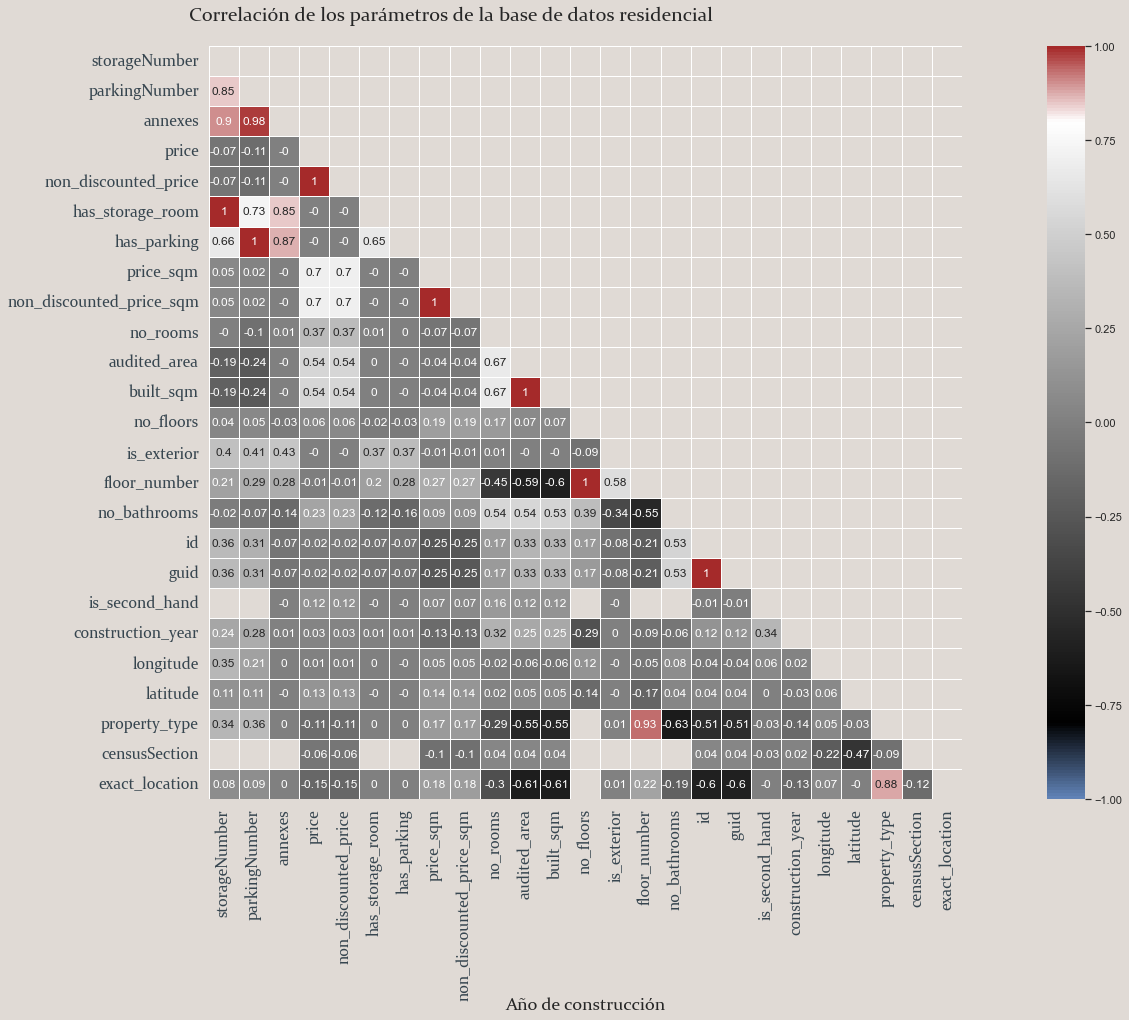

In [185]:
# Draw the heatmap with the mask and correct aspect ratio
sns.set(rc={'axes.facecolor':dp.rgb(dp.BEIGE), 'figure.facecolor':dp.rgb(dp.BEIGE)})

fig, ax = plt.subplots(figsize=(16*1.5,9*1.5), facecolor=dp.rgb(dp.BEIGE))

plot_properties = {'cbar':True, 'linewidths':.5,'mask':mask,'cmap':cmap,'vmin':-1,'vmax':1,'center':0,'square':True}
sns.heatmap(corr, ax=ax, annot=True, **plot_properties)

plt.suptitle('Correlación de los parámetros de la base de datos residencial', **titlestyle)
plt.ylabel('')
plt.xlabel('Año de construcción', **labelstyle)
plt.tight_layout()

# Change tick styles
ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
for label in ax.get_xticklabels(): label.set_fontproperties(ticks_style)
for label in ax.get_yticklabels(): label.set_fontproperties(ticks_style)

plt.savefig(f'EDA/plot/RealEstate/Corr.png')
plt.show()
plt.close()

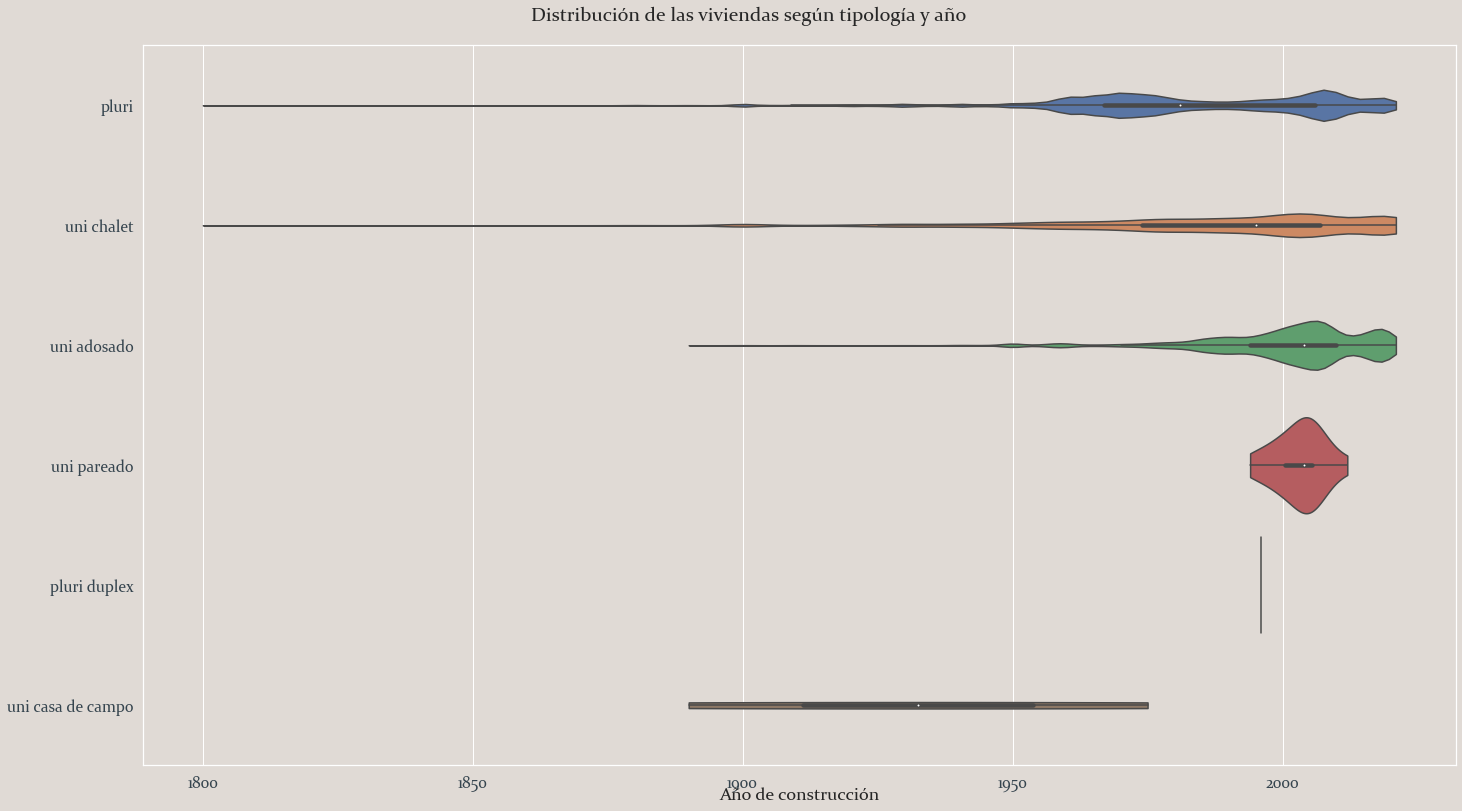

In [140]:
titlestyle = {'size':20, 'fontname':'Constantia','ha':'center', 'va':'center'}
labelstyle = {'size':18, 'fontname':'Constantia','ha':'center', 'va':'center'}
ticks_style = font_manager.FontProperties(family='Constantia', size=16, weight='normal', stretch='normal')
tickstyle = {'colors':dp.rgb(dp.CHARCOAL)}
sns.set(rc={'axes.facecolor':dp.rgb(dp.BEIGE), 'figure.facecolor':dp.rgb(dp.BEIGE)})

subplot_properties = {'figsize':(20,11.25), 'facecolor':dp.rgb(dp.BEIGE)}

fig, ax = plt.subplots(**subplot_properties)
plot_properties = {'cbar':True, 'linewidths':.5,'mask':mask,'cmap':cmap,'vmin':-1,'vmax':1,'annot':True,'center':0,'square':True}
sns.violinplot(data=df, x="construction_year", y="tipo", ax=ax, cut=0)
plt.suptitle('Distribución de las viviendas según tipología y año', **titlestyle)
plt.ylabel('')
plt.xlabel('Año de construcción', **labelstyle)
plt.tight_layout()

# Change tick styles
ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
for label in ax.get_xticklabels(): label.set_fontproperties(ticks_style)
for label in ax.get_yticklabels(): label.set_fontproperties(ticks_style)

plt.savefig(f'EDA/plot/RealEstate/Distribucion viviendas tipologia año.png')
plt.show()
plt.close()


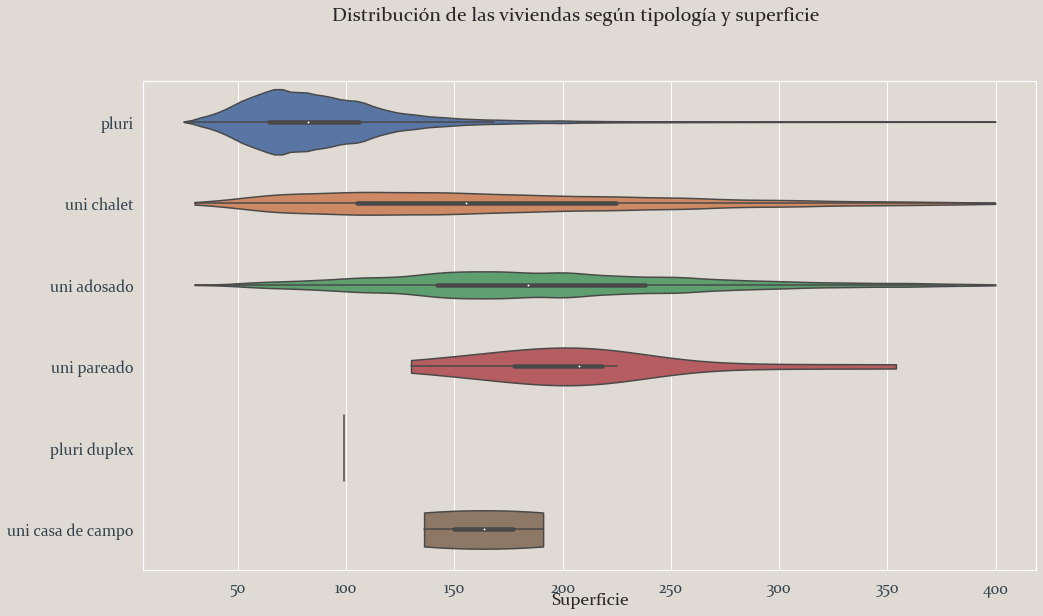

In [149]:
subplot_properties = {'figsize':(16,9), 'facecolor':dp.rgb(dp.BEIGE)}

fig, ax = plt.subplots(**subplot_properties)
plot_properties = {'cbar':True, 'linewidths':.5,'mask':mask,'cmap':cmap,'vmin':-1,'vmax':1,'annot':True,'center':0,'square':True}
sns.violinplot(data=df, x="built_sqm", y="tipo", ax=ax, cut=0)

plt.suptitle('Distribución de las viviendas según tipología y superficie', **titlestyle)
plt.ylabel('')
plt.xlabel('Superficie', **labelstyle)

# Change tick styles
ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
for label in ax.get_xticklabels(): label.set_fontproperties(ticks_style)
for label in ax.get_yticklabels(): label.set_fontproperties(ticks_style)

plt.savefig(f'EDA/plot/RealEstate/Distribucion viviendas tipologia superficie.png')
plt.show()
plt.close()

In [150]:
df['age_at_buytime'] = df.Fecha_Compraventa - df.construction_year_date
df['age_at_buytime'] = df['age_at_buytime'].apply(lambda x: x.days/365)
dg = df.loc[df['age_at_buytime'].notna()].copy()
dg.age_at_buytime = dg.age_at_buytime.astype('int')
dg['age_at_buytime_interval'] = pd.cut(dg.age_at_buytime, bins=[-10,0,5,10,20,30,40,50,60,250])
# dg = pd.get_dummies(dg, columns=['age_at_buytime_interval'])
aab = dg.groupby([pd.Grouper(freq='YS',key='Fecha_Compraventa',convention='start'),'age_at_buytime_interval']).count().reset_index()
aab = aab.pivot(index='Fecha_Compraventa', columns='age_at_buytime_interval', values='id').reset_index()
aab = aab.iloc[:-1]
aab.head()

age_at_buytime_interval,Fecha_Compraventa,"(-10, 0]","(0, 5]","(5, 10]","(10, 20]","(20, 30]","(30, 40]","(40, 50]","(50, 60]","(60, 250]"
0,2010-01-01,1701,5488,1918,2131,1749,4020,5666,1885,2555
1,2011-01-01,1415,2934,1089,1313,1006,1938,3514,2061,2252
2,2012-01-01,2969,4262,1621,1959,1390,3876,4825,2566,2296
3,2013-01-01,1279,4695,2910,2464,1645,3875,4697,2172,2199
4,2014-01-01,1330,5727,5730,5458,3138,5874,7269,3510,3578


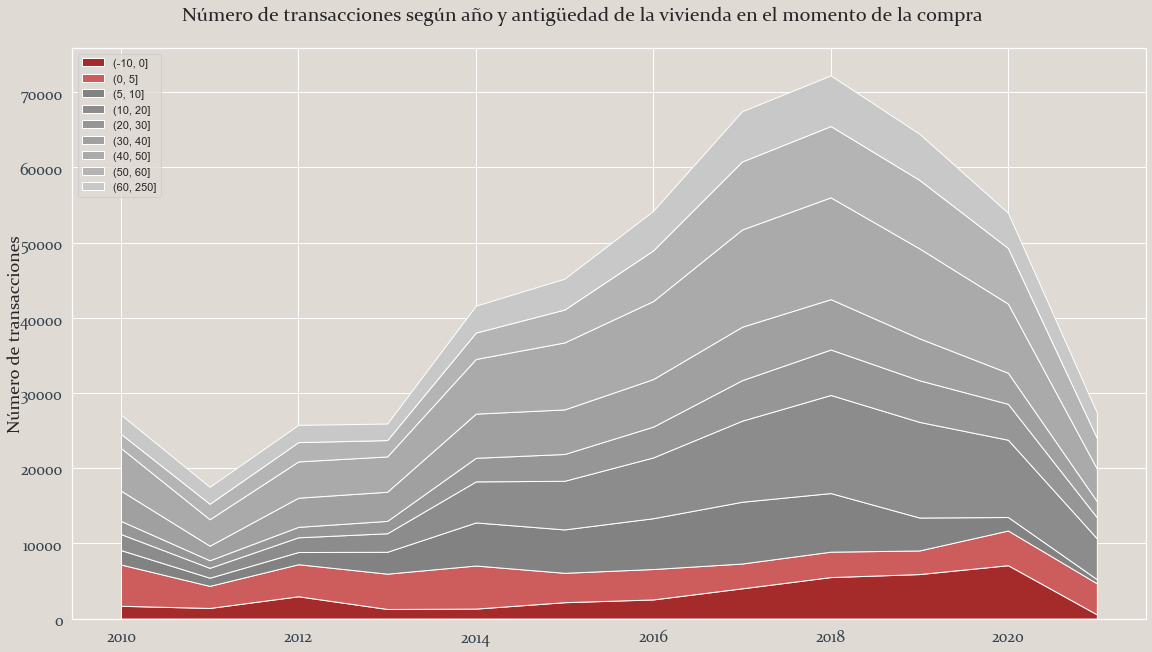

In [173]:
y = tuple([aab[col] for i, col in enumerate(aab.columns) if i >0 ])
labels = [col for i, col in enumerate(aab.columns) if i >0 ]

fig, ax = plt.subplots(**subplot_properties)
colors = [dp.rgb(dp.RED), dp.rgb((205, 92, 92)), dp.rgb((130, 130, 130)),
             dp.rgb((140, 140, 140)), dp.rgb((150, 150, 150)), dp.rgb((160, 160, 160)),
             dp.rgb((170, 170, 170)), dp.rgb((180,180,180)), dp.rgb((200, 200, 200))]
ax.stackplot(aab.iloc[:,0], y, labels=labels, colors=colors)
ax.legend(loc='upper left')

ax.grid(True)
plt.suptitle('Número de transacciones según año y antigüedad de la vivienda en el momento de la compra', **titlestyle)
plt.ylabel('Número de transacciones', **labelstyle)
# plt.xlabel('Superficie', **labelstyle)
plt.tight_layout()

# Change tick styles
ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
for label in ax.get_xticklabels(): label.set_fontproperties(ticks_style)
for label in ax.get_yticklabels(): label.set_fontproperties(ticks_style)
plt.savefig(f'EDA/plot/RealEstate/N transacciones año antigüedad.png')
plt.show()
plt.close()

In [19]:
df['age_at_buytime'] = df.Fecha_Compraventa - df.construction_year_date
df['age_at_buytime'] = df['age_at_buytime'].apply(lambda x: x.days/365)
dg = df.loc[df['age_at_buytime'].notna()].copy()
dg.age_at_buytime = dg.age_at_buytime.astype('int')
dg['age_at_buytime_interval'] = pd.cut(dg.age_at_buytime, bins=[-10,0,5,10,20,30,40,50,60,250])
# dg = pd.get_dummies(dg, columns=['age_at_buytime_interval'])
aab = dg.groupby([pd.Grouper(freq='MS',key='Fecha_Compraventa',convention='start'),'age_at_buytime_interval']).count().reset_index()
aab = aab.pivot(index='Fecha_Compraventa', columns='age_at_buytime_interval', values='id').reset_index()
aab = aab.iloc[:-1]
aab.iloc[:,1:] = aab.iloc[:,1:].div(aab.iloc[:,1:].sum(axis=1), axis=0)
aab

age_at_buytime_interval,Fecha_Compraventa,"(-10, 0]","(0, 5]","(5, 10]","(10, 20]","(20, 30]","(30, 40]","(40, 50]","(50, 60]","(60, 250]"
0,2010-01-01,0.009299,0.217454,0.070100,0.068670,0.060801,0.152361,0.232475,0.082260,0.106581
1,2010-02-01,0.009492,0.275265,0.066443,0.067002,0.061418,0.139028,0.198213,0.086544,0.096594
2,2010-03-01,0.013397,0.247191,0.064823,0.085134,0.066551,0.156007,0.206137,0.065687,0.095073
3,2010-04-01,0.011358,0.232167,0.068151,0.090413,0.070423,0.146751,0.214448,0.070877,0.095411
4,2010-05-01,0.021853,0.198427,0.072990,0.069056,0.068619,0.159528,0.230769,0.081294,0.097465
...,...,...,...,...,...,...,...,...,...,...
143,2021-12-01,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.400000,0.200000,0.200000
144,2022-01-01,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.333333,0.000000
145,2022-02-01,0.000000,0.000000,0.000000,0.250000,0.250000,0.000000,0.000000,0.250000,0.250000
146,2022-03-01,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.250000,0.250000


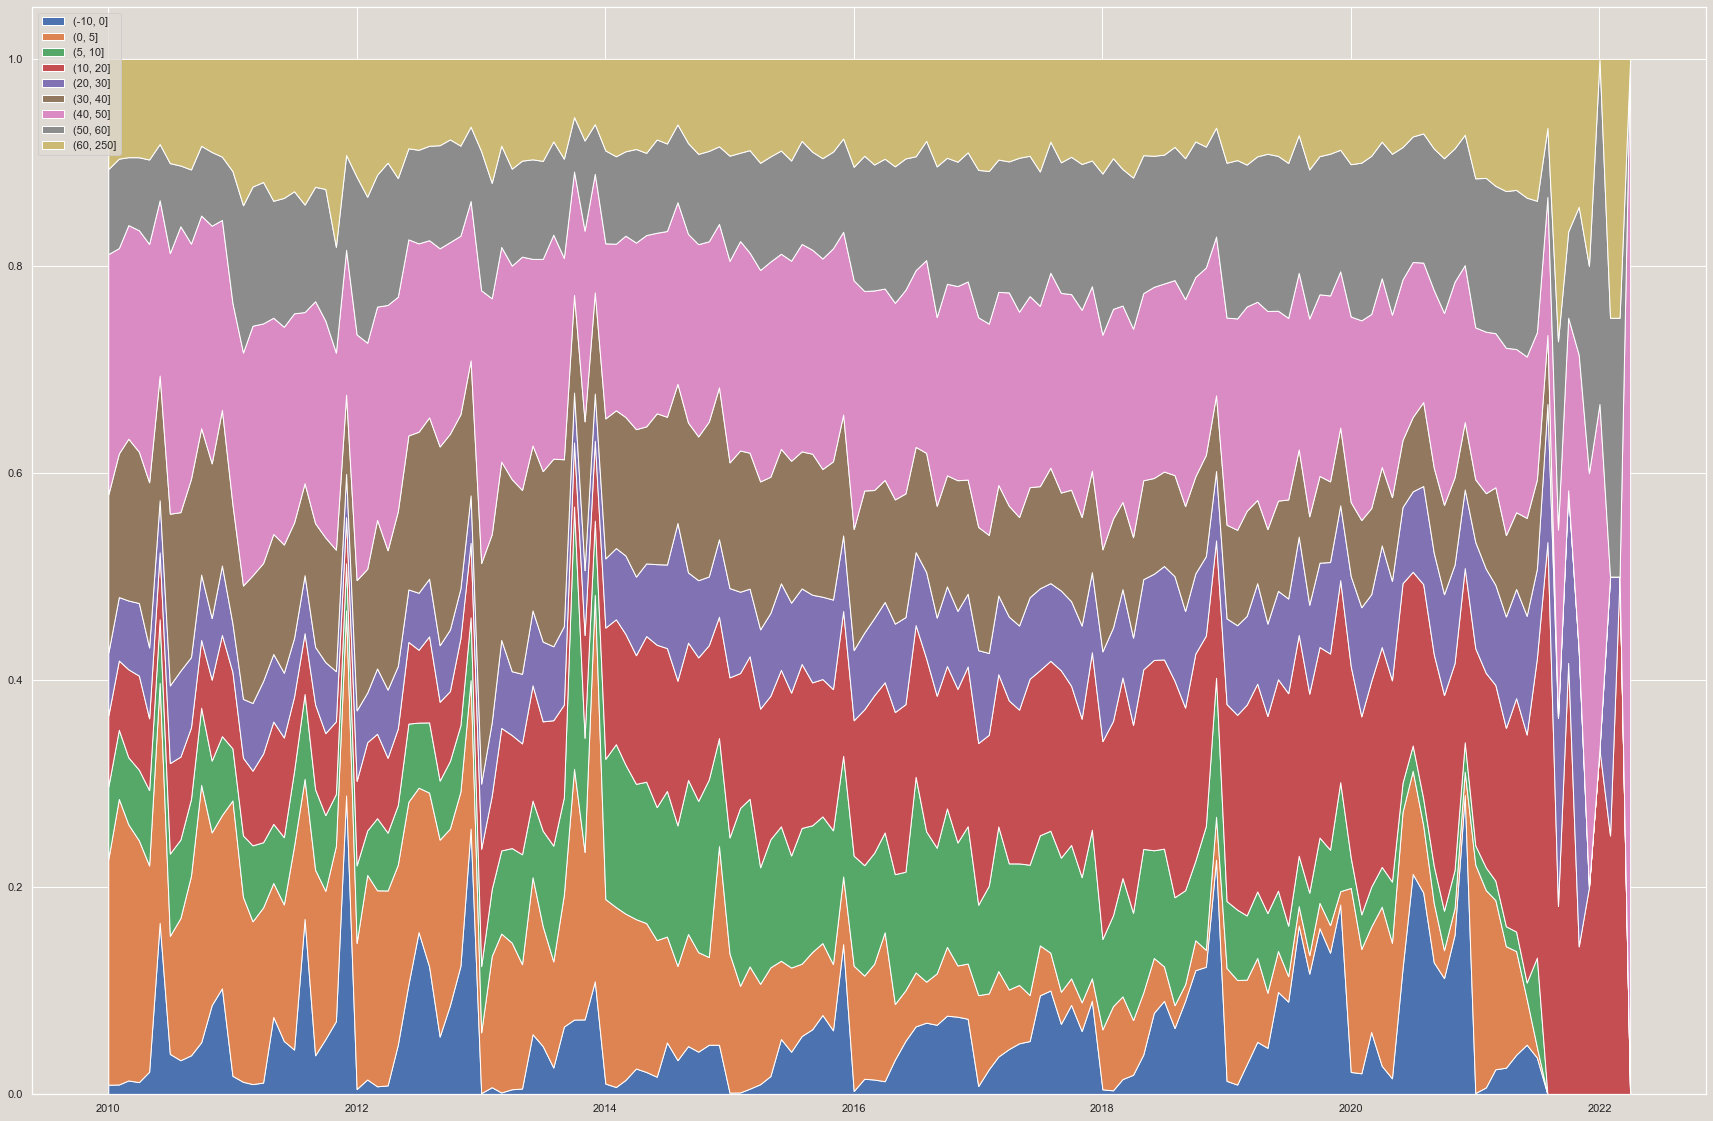

In [ ]:
y = tuple([aab[col] for i, col in enumerate(aab.columns) if i >0 ])
labels = [col for i, col in enumerate(aab.columns) if i >0 ]
fig, ax = plt.subplots(figsize = (30,20), facecolor=dp.rgb(dp.BEIGE))
ax.stackplot(aab.iloc[:,0], y, labels=labels)
ax.legend(loc='upper left')

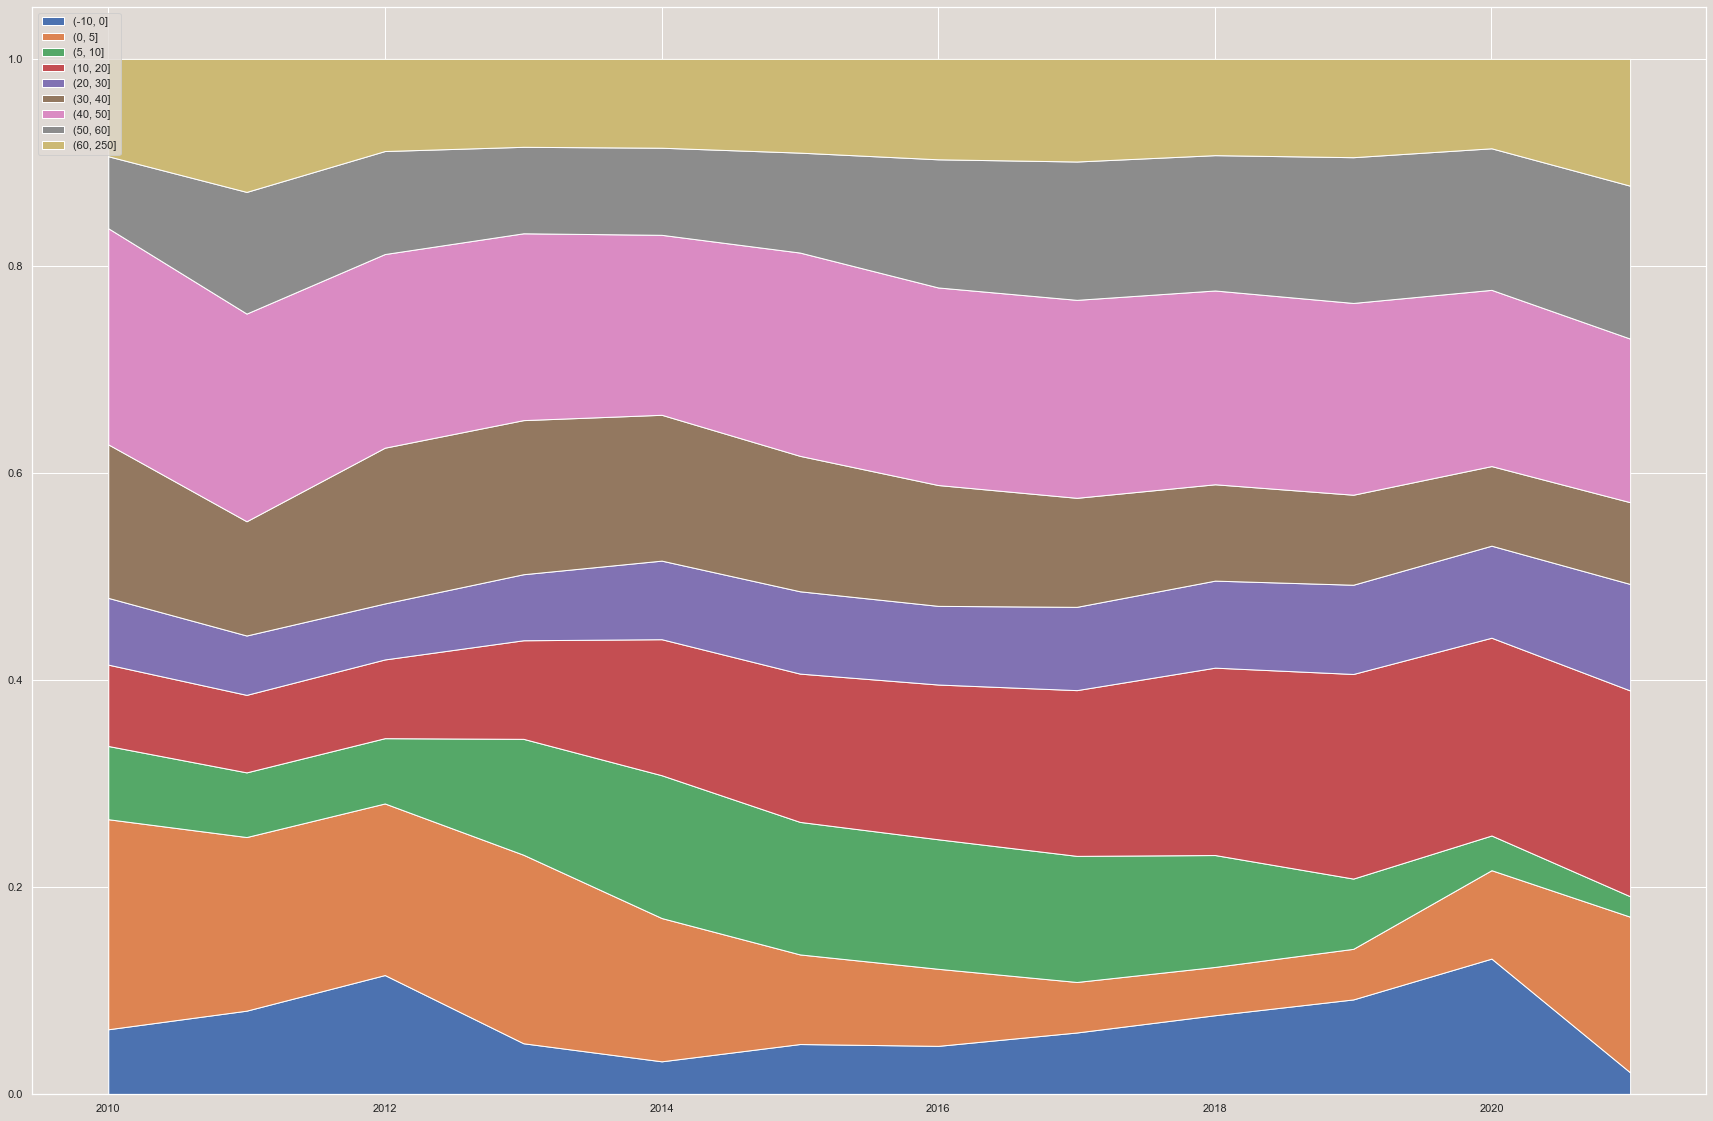

In [ ]:
df['age_at_buytime'] = df.Fecha_Compraventa - df.construction_year_date
df['age_at_buytime'] = df['age_at_buytime'].apply(lambda x: x.days/365)
dg = df.loc[df['age_at_buytime'].notna()].copy()
dg.age_at_buytime = dg.age_at_buytime.astype('int')
dg['age_at_buytime_interval'] = pd.cut(dg.age_at_buytime, bins=[-10,0,5,10,20,30,40,50,60,250])
# dg = pd.get_dummies(dg, columns=['age_at_buytime_interval'])
aab = dg.groupby([pd.Grouper(freq='YS',key='Fecha_Compraventa',convention='start'),'age_at_buytime_interval']).count().reset_index()
aab = aab.pivot(index='Fecha_Compraventa', columns='age_at_buytime_interval', values='id').reset_index()
aab = aab.iloc[:-1]
aab.iloc[:,1:] = aab.iloc[:,1:].div(aab.iloc[:,1:].sum(axis=1), axis=0)

y = tuple([aab[col] for i, col in enumerate(aab.columns) if i >0 ])
labels = [col for i, col in enumerate(aab.columns) if i >0 ]
fig, ax = plt.subplots(figsize = (30,20), facecolor=dp.rgb(dp.BEIGE))
ax.stackplot(aab.iloc[:,0], y, labels=labels)
ax.legend(loc='upper left')

<AxesSubplot:>

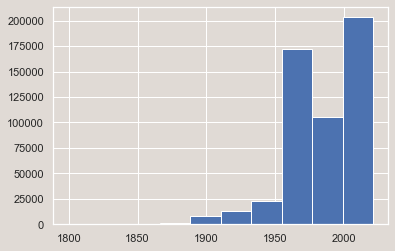

In [ ]:
df.construction_year.hist()

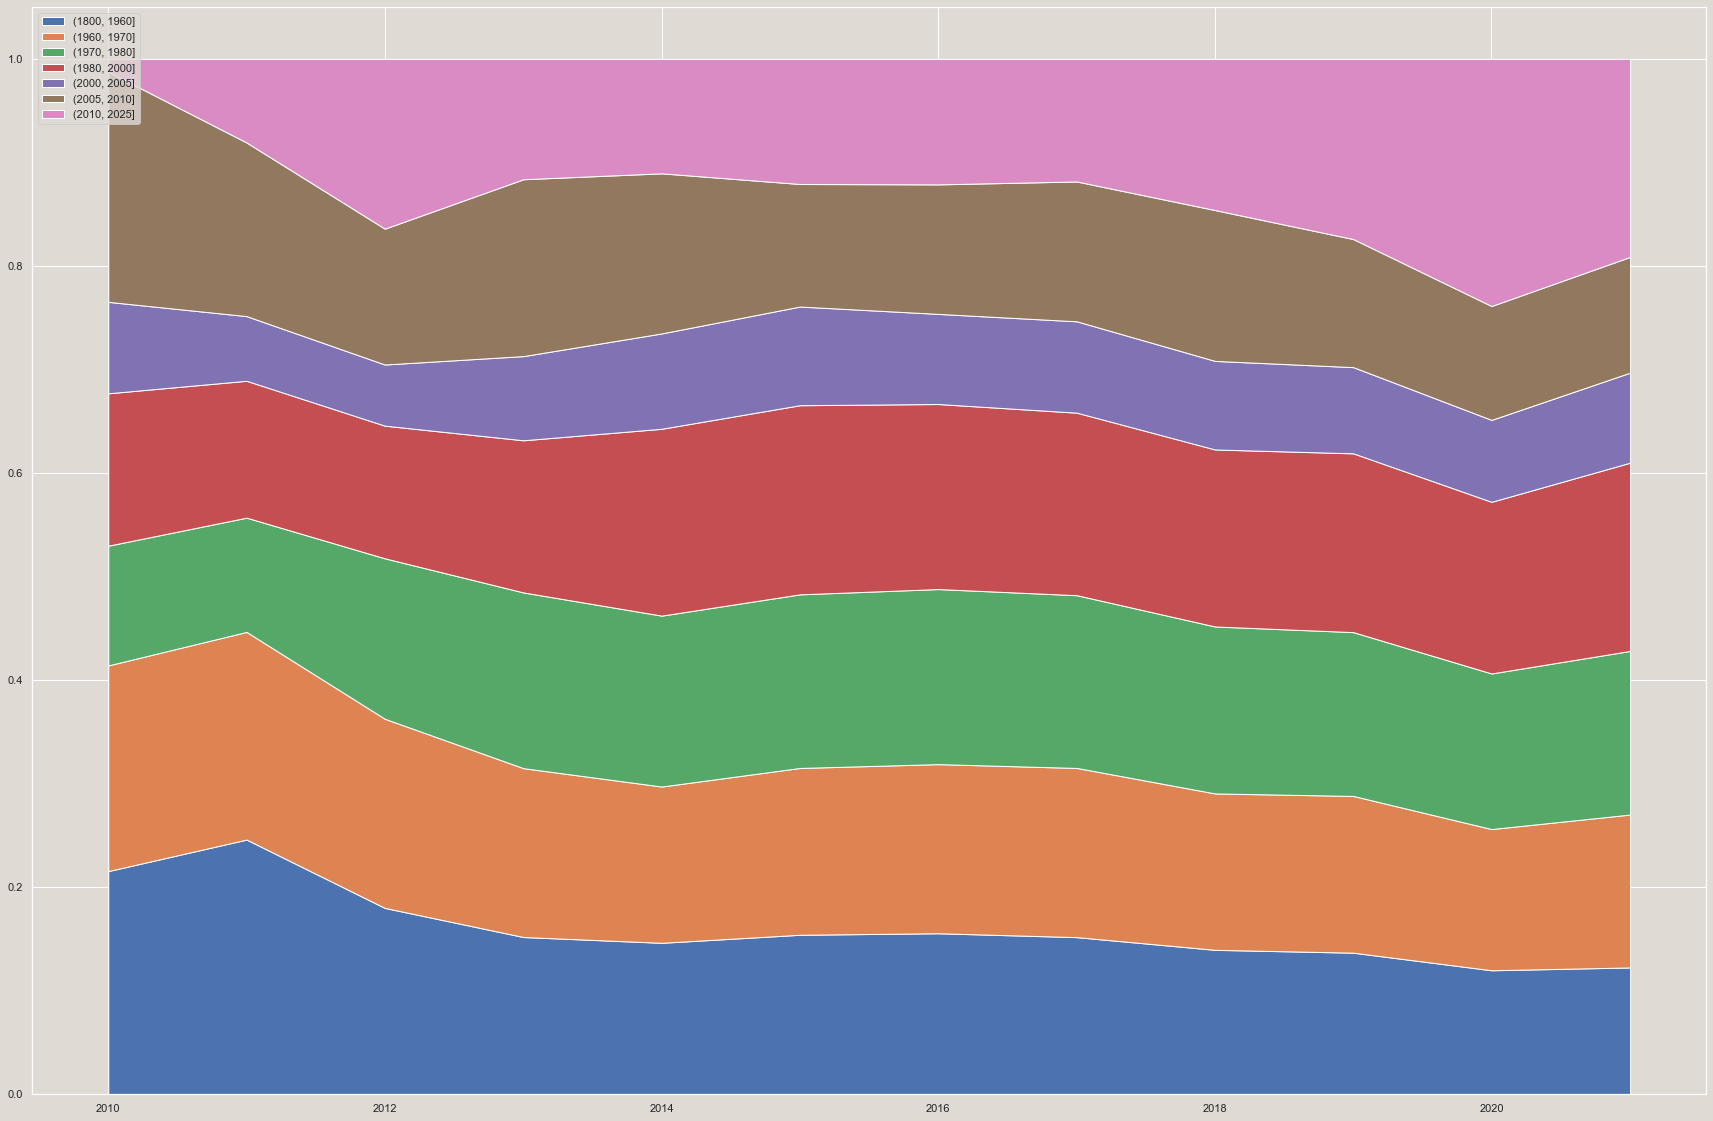

In [ ]:
dg['construction_year_interval'] = pd.cut(dg.construction_year, bins=[1800,1960,1970,1980,2000,2005,2010,2025])
# dg = pd.get_dummies(dg, columns=['construction_year_interval'])

aab = dg.groupby([pd.Grouper(freq='YS',key='Fecha_Compraventa',convention='start'),'construction_year_interval']).count().reset_index()
aab = aab.pivot(index='Fecha_Compraventa', columns='construction_year_interval', values='id').reset_index()
aab = aab.iloc[:-1]
aab.iloc[:,1:] = aab.iloc[:,1:].div(aab.iloc[:,1:].sum(axis=1), axis=0)

y = tuple([aab[col] for i, col in enumerate(aab.columns) if i >0 ])
labels = [col for i, col in enumerate(aab.columns) if i >0 ]
fig, ax = plt.subplots(figsize = (30,20), facecolor=dp.rgb(dp.BEIGE))
ax.stackplot(aab.iloc[:,0], y, labels=labels)
ax.legend(loc='upper left')

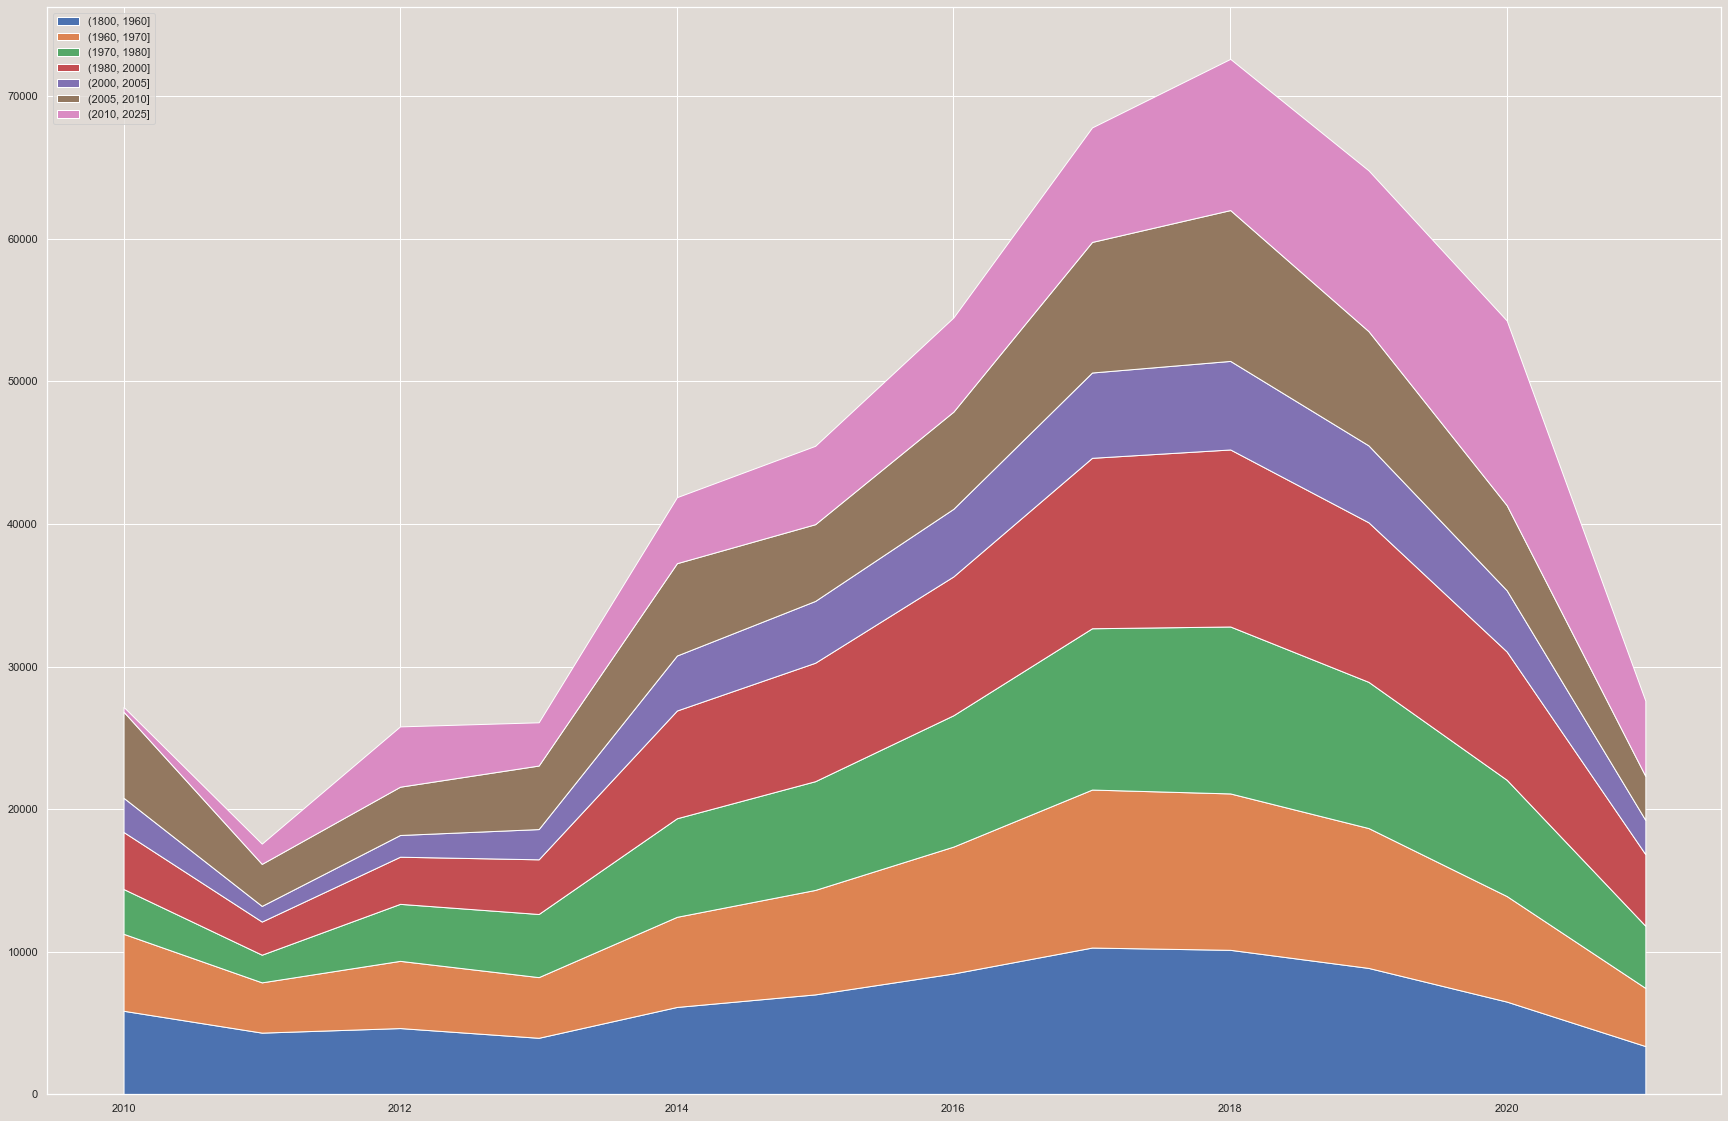

In [ ]:
dg['construction_year_interval'] = pd.cut(dg.construction_year, bins=[1800,1960,1970,1980,2000,2005,2010,2025])
# dg = pd.get_dummies(dg, columns=['construction_year_interval'])

aab = dg.groupby([pd.Grouper(freq='YS',key='Fecha_Compraventa',convention='start'),'construction_year_interval']).count().reset_index()
aab = aab.pivot(index='Fecha_Compraventa', columns='construction_year_interval', values='id').reset_index()
aab = aab.iloc[:-1]
# aab.iloc[:,1:] = aab.iloc[:,1:].div(aab.iloc[:,1:].sum(axis=1), axis=0)

y = tuple([aab[col] for i, col in enumerate(aab.columns) if i >0 ])
labels = [col for i, col in enumerate(aab.columns) if i >0 ]
fig, ax = plt.subplots(figsize = (30,20), facecolor=dp.rgb(dp.BEIGE))
ax.stackplot(aab.iloc[:,0], y, labels=labels)
ax.legend(loc='upper left')

Dónde están las viviendas que se compran antes de que se construyan ?

<AxesSubplot:xlabel='townName', ylabel='id'>

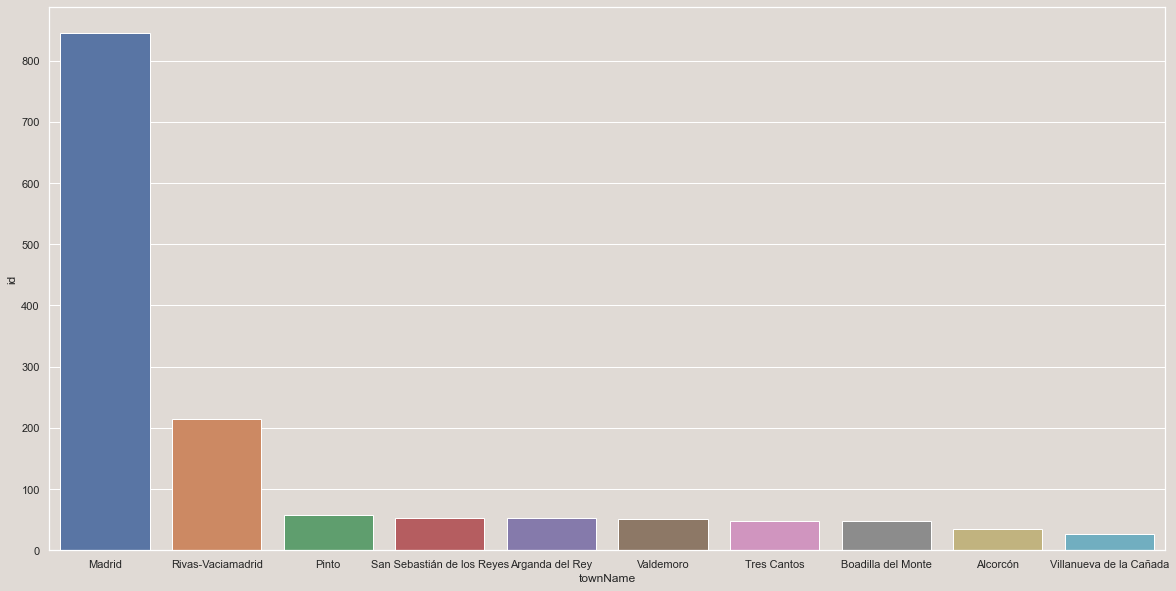

In [ ]:
cities = df.loc[df.age_at_buytime < 0].groupby('townName').count().reset_index().sort_values(by='id',ascending=False).head(10)
fig, ax = plt.subplots(figsize = (20,10), facecolor=dp.rgb(dp.BEIGE))
sns.barplot(data=cities, x="townName", y="id",ax=ax)


In [13]:
proj = pyproj.Transformer.from_crs(4326, 25830, always_xy=True)
df[['x', 'y']] = df.apply(lambda row: proj.transform(row.longitude, row.latitude), axis=1, result_type='expand')

c:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\geodataframe.py:35: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)
c:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\geoseries.py:133: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = from_shapely(s.values)
c:\Users\alex\AppData\Loc

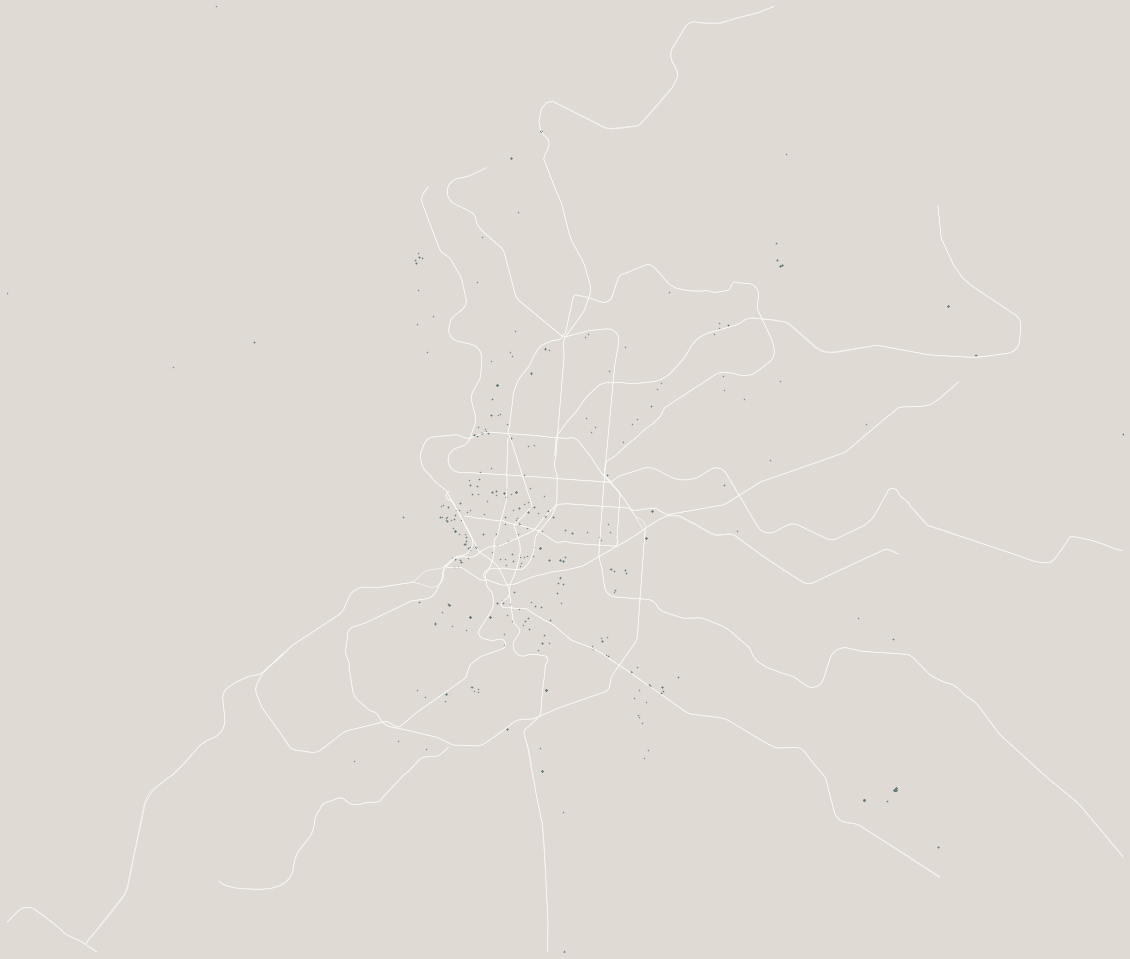

In [188]:
madrid_sobre_plano = df.loc[(df.age_at_buytime < 0) & (df.townName == 'Madrid')].copy()
madrid_sobre_plano

# Results
figsize = (20, 18)

metro = gpd.read_file(r'data\transport\Datos_abiertos__Elementos_de_la_Red_de_Metro.geojson')
metro = metro.to_crs("EPSG:25830")


fig, ax = plt.subplots(figsize=figsize, facecolor=dp.rgb(dp.BEIGE))

ax.set_aspect('equal')
ax.set_axis_off()

# Transaction points
plt.scatter(madrid_sobre_plano['x'], madrid_sobre_plano['y'], color=dp.rgb(dp.DARK_GREEN), s=.2)
metro.plot(ax=ax, color='w', linewidth=.5)

# Province shape plot
# provinces.plot(ax=ax, color='gray', linewidth=2)

# plot_margin = 20_000
# offset = 5_000
# offsetS = 2_000

# Show area of extraction
# lines = [[(x0, y0-offset), (x0, y1+offset)], [(x1, y0-offset), (x1, y1+offset)], [(x0-offset, y0), (x1+offset, y0)], [(x0-offset, y1), (x1+offset, y1)]]
# lc = mc.LineCollection(lines, color=GREY, linewidths=2)
# ax.add_collection(lc)

# # Show coordinates of extraction
# labels = [(x0, y0-offset-offsetS, numeric_text(x0)), (x0, y1+offset+offsetS, numeric_text(x0)), (x1, y0-offset-offsetS, numeric_text(x1)), (x1, y1+offset+offsetS, numeric_text(x1)),
#         (x0-2.5*offset, y0, numeric_text(y0)), (x1+2.5*offset, y0, numeric_text(y0)), (x0-2.5*offset, y1, numeric_text(y1)), (x1+2.5*offset, y1, numeric_text(y1))]
# for x,y,text in labels:
#     ax.text(x, y, text, **labelstyle)

lx0 = madrid_sobre_plano.x.min() #357_000 - plot_margin
lx1 = madrid_sobre_plano.x.max() # 508_000 + plot_margin
ly0 = madrid_sobre_plano.y.min() # 4_405_000 - plot_margin
ly1 = madrid_sobre_plano.y.max() # 4_560_000 + plot_margin
ax.set_xlim(lx0,lx1)
ax.set_ylim(ly0,ly1)

plt.show()
plt.close()

In [ ]:
# madrid_sobre_plano['censusSection'] = madrid_sobre_plano.censusSection.astype('str')
# madrid_sobre_plano['censusSection'] = madrid_sobre_plano['censusSection'].str.replace('.0$','',regex=True)
# madrid_sobre_plano['censusSection'] = madrid_sobre_plano.censusSection.astype('int')
censiones_censales = list(madrid_sobre_plano['censusSection'])

In [247]:
ccss = madrid_sobre_plano.groupby('censusSection').count().sort_values(by='id',ascending=False).head(5).index

c:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\plotting.py:187: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  segments = [np.array(linestring)[:, :2] for linestring in geoms]


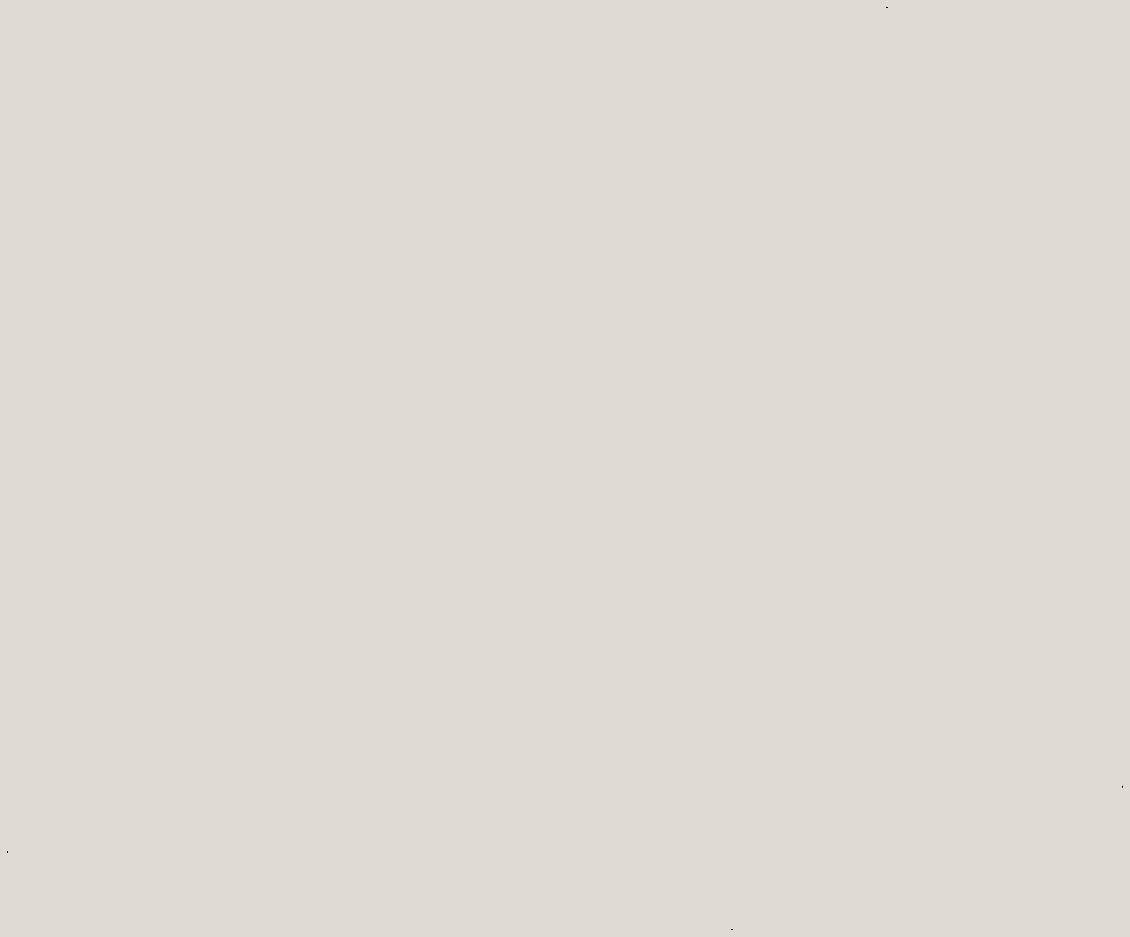

In [269]:
ccss = madrid_sobre_plano.groupby('censusSection').count().sort_values(by='id',ascending=False).head(1).index
madrid_plano = df.loc[(df.censusSection.isin(ccss)) & (df.age_at_buytime < 0)].copy()

# Results
figsize = (20, 18)

fig, ax = plt.subplots(figsize=figsize, facecolor=dp.rgb(dp.BEIGE))

ax.set_aspect('equal')
ax.set_axis_off()

# Transaction points
plt.scatter(madrid_plano['x'], madrid_plano['y'], c=madrid_plano.censusSection, s=.2)
metro.plot(ax=ax, color='grey', linewidth=.5)

# Province shape plot
# provinces.plot(ax=ax, color='gray', linewidth=2)

# plot_margin = 20_000
# offset = 5_000
# offsetS = 2_000

# Show area of extraction
# lines = [[(x0, y0-offset), (x0, y1+offset)], [(x1, y0-offset), (x1, y1+offset)], [(x0-offset, y0), (x1+offset, y0)], [(x0-offset, y1), (x1+offset, y1)]]
# lc = mc.LineCollection(lines, color=GREY, linewidths=2)
# ax.add_collection(lc)

# # Show coordinates of extraction
# labels = [(x0, y0-offset-offsetS, numeric_text(x0)), (x0, y1+offset+offsetS, numeric_text(x0)), (x1, y0-offset-offsetS, numeric_text(x1)), (x1, y1+offset+offsetS, numeric_text(x1)),
#         (x0-2.5*offset, y0, numeric_text(y0)), (x1+2.5*offset, y0, numeric_text(y0)), (x0-2.5*offset, y1, numeric_text(y1)), (x1+2.5*offset, y1, numeric_text(y1))]
# for x,y,text in labels:
#     ax.text(x, y, text, **labelstyle)

lx0 = madrid_plano.x.min() #357_000 - plot_margin
lx1 = madrid_plano.x.max() # 508_000 + plot_margin
ly0 = madrid_plano.y.min() # 4_405_000 - plot_margin
ly1 = madrid_plano.y.max() # 4_560_000 + plot_margin
ax.set_xlim(lx0,lx1)
ax.set_ylim(ly0,ly1)

plt.show()
plt.close()

# Cómo ha variado el precio de la vivienda en cada caso ?

Calculamos los precios de las viviendas ajustados a la inflación.

In [10]:
def inflation_adjustment_series(cpi_series):
    """
    Given a CPI Series, get the last valid value and use it to return a series of adjustment factors,
    ready to be used as OLD_PRICE_SERIES * adjustment_series = ADJUSTED_PRICE

    Args:
        cpi_series : pd.Series with datetimeindex

    Returns:
        adjustment_series : pd.Series
    """
    new_CPI = cpi_series.dropna()[-1]
    adjustment_series = new_CPI/cpi_series
    return adjustment_series

finance_path = 'data/finance.sqlite'

dfin = dp.get_df_from(finance_path, 'be2501')
dfin = dp.set_datetime_axis(dfin, 'DateTime', '%Y-%m-%d')
inflation_adjustment = inflation_adjustment_series(dfin['BE_25_1.1'])

In [11]:
def adjust_val_to_inflation(inflation_adjustment, df, row, datecol, valcol):
    adj = inflation_adjustment[df.loc[row, datecol]]
    return df.loc[row, valcol] * adj
df.reset_index(drop=True, inplace=True)
df['price_adj'] = [adjust_val_to_inflation(inflation_adjustment, df, row, 'Fecha_Compraventa', 'price') for row, values in df.iterrows()]
df['price_sqm_adj'] = df.price_adj / df.built_sqm

<AxesSubplot:xlabel='price_adj', ylabel='tipo'>

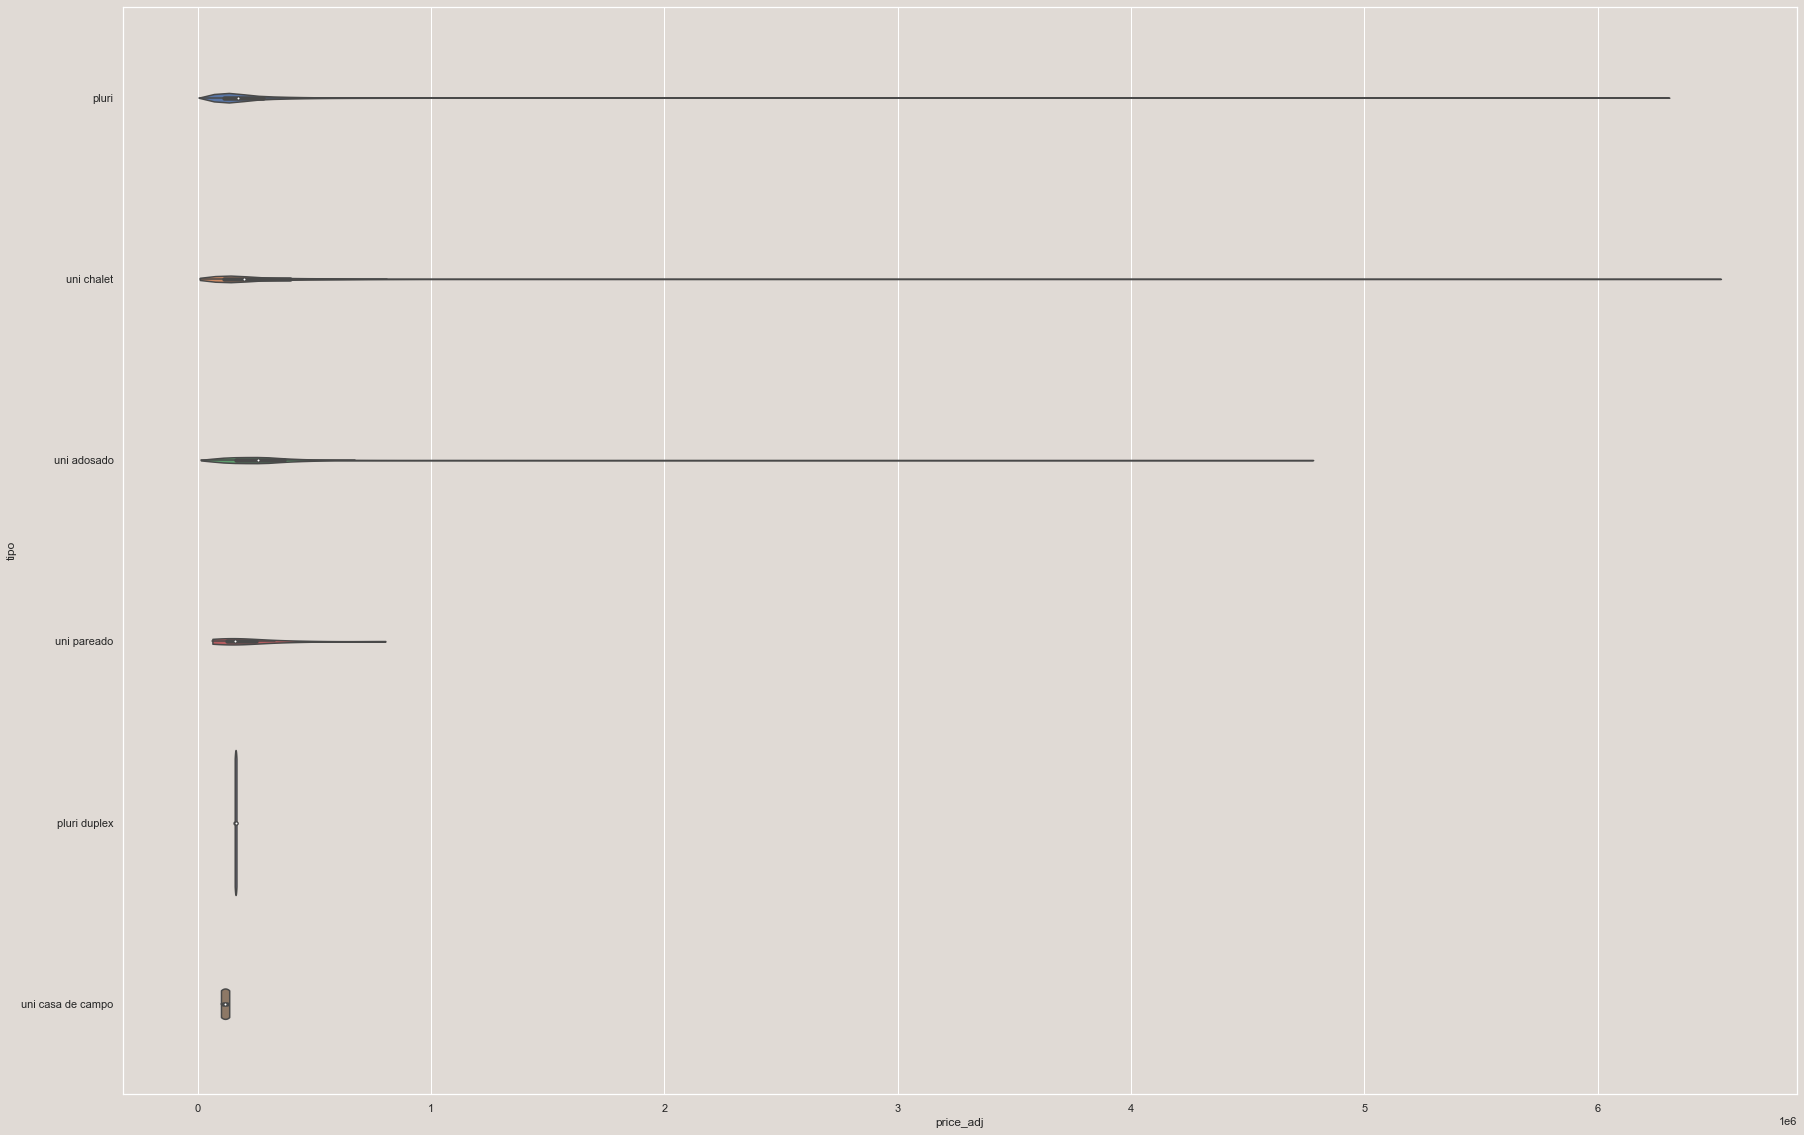

In [ ]:
fig, ax = plt.subplots(figsize = (30,20), facecolor=dp.rgb(dp.BEIGE))
plot_properties = {'cbar':True, 'linewidths':.5,'mask':mask,'cmap':cmap,'vmin':-1,'vmax':1,'annot':True,'center':0,'square':True}

sns.violinplot(data=df, x="price_adj", y="tipo", ax=ax, cut=0)

<AxesSubplot:>

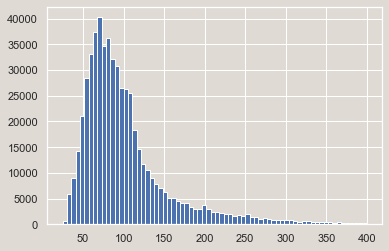

In [442]:
df.built_sqm.hist(bins=70)

In [411]:
nbins = 50
dg = df.loc[(df.townName == 'Madrid') & (df.tipo == 'pluri') & (df.price_sqm_adj<10000) & (df.built_sqm<150)]

x = dg.Fecha_Compraventa.apply(lambda x:x.timestamp()).astype('int')
y = dg.built_sqm

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

In [412]:
labelstyle = {'size':16, 'fontname':'Constantia','ha':'center', 'va':'center', 'labelpad':20}
ticks_style = font_manager.FontProperties(family='Constantia', size=16, weight='normal', stretch='normal')
tickstyle = {'colors':dp.rgb(dp.CHARCOAL)}

importlib.reload(dp)

hc = [dp.hex_color(dp.BEIGE), dp.hex_color((150, 121, 105)), dp.hex_color(dp.WINE), '#000']
th = [0, 0.33,.66,1]
cdict = NonLinCdict(th, hc)
cmap_bkrw = LinearSegmentedColormap('test', cdict)

Cuántas viviendas se han vendido en cada año en función de su superficie ?

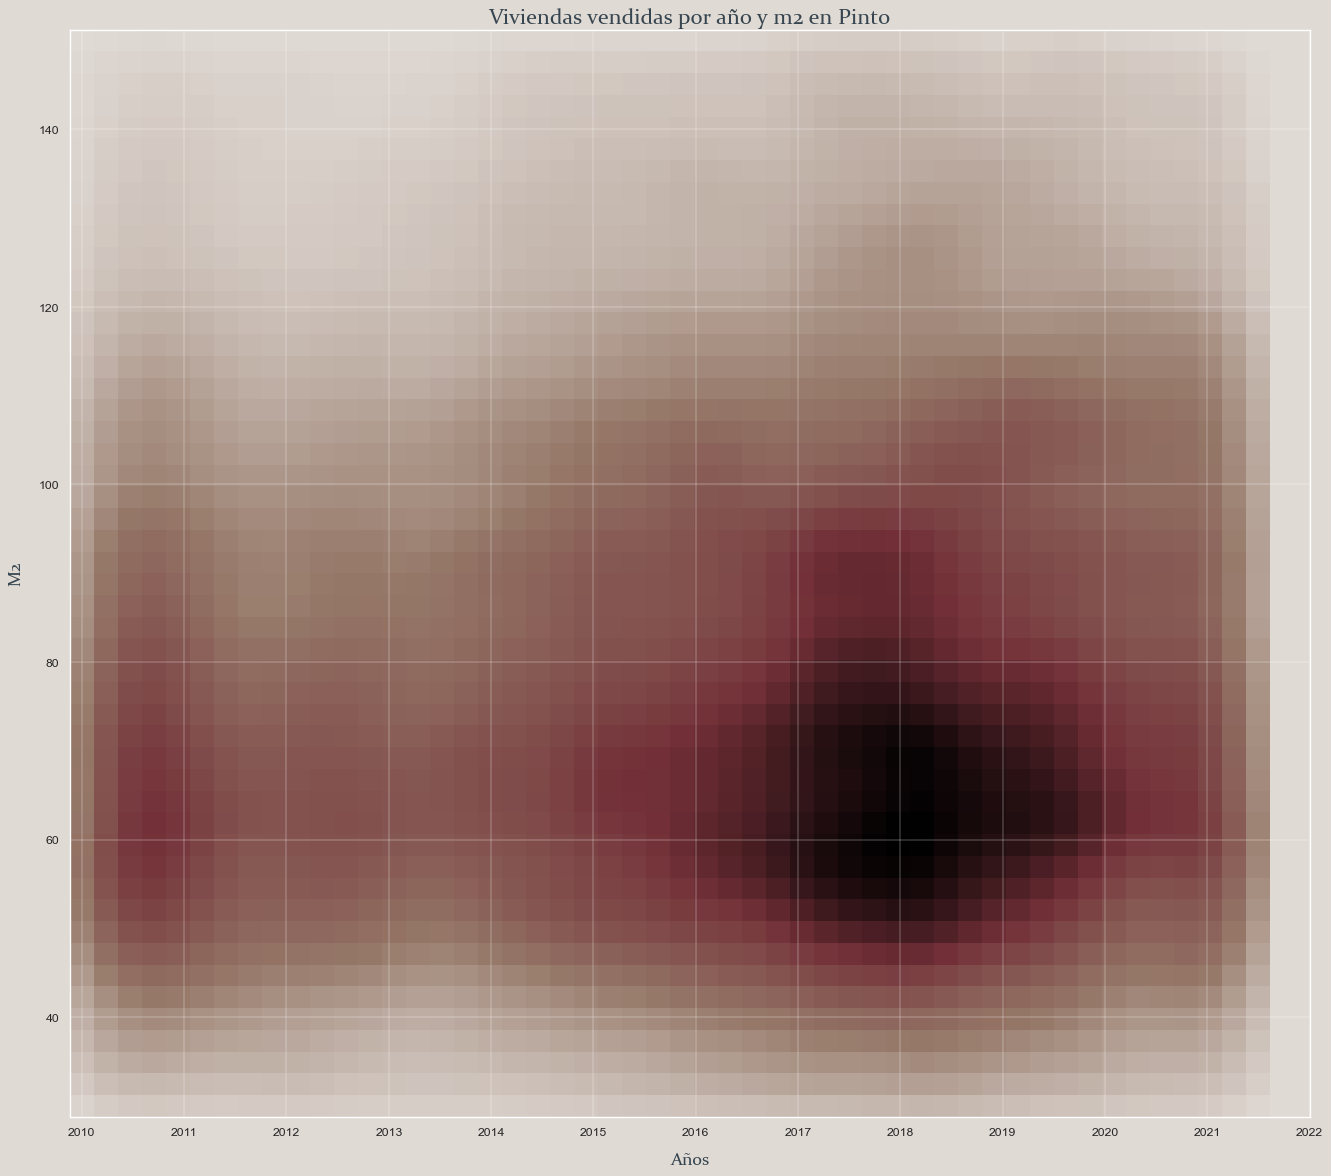

In [413]:
fig, ax = plt.subplots(figsize=(20, 18), dpi=80)
ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=cmap_bkrw, zorder=0)

ax.grid(True, color="w", lw=.3)

# plt.scatter(dg.Fecha_Compraventa.apply(lambda x:x.timestamp()).astype('int'), dg.built_sqm)

minyear = dg.Fecha_Compraventa.min().year
maxyear = dg.Fecha_Compraventa.max().year+1
locs = []
labels = []

for year in range(minyear, maxyear+1, 1):
    locs.append(pd.to_datetime(f'{year}-01-01').timestamp())
    labels.append(year)
plt.xticks(locs, labels)

plt.title(f'Viviendas vendidas por año y m2 en Pinto', color=dp.rgb(dp.CHARCOAL), size=20, fontname='Constantia')
ax.set_xlabel('Años', color=dp.rgb(dp.CHARCOAL), **labelstyle)
ax.set_ylabel('M2', color=dp.rgb(dp.CHARCOAL), **labelstyle)

plt.show()

In [466]:
dg.price_sqm_adj.quantile(.05)

973.6636921402252

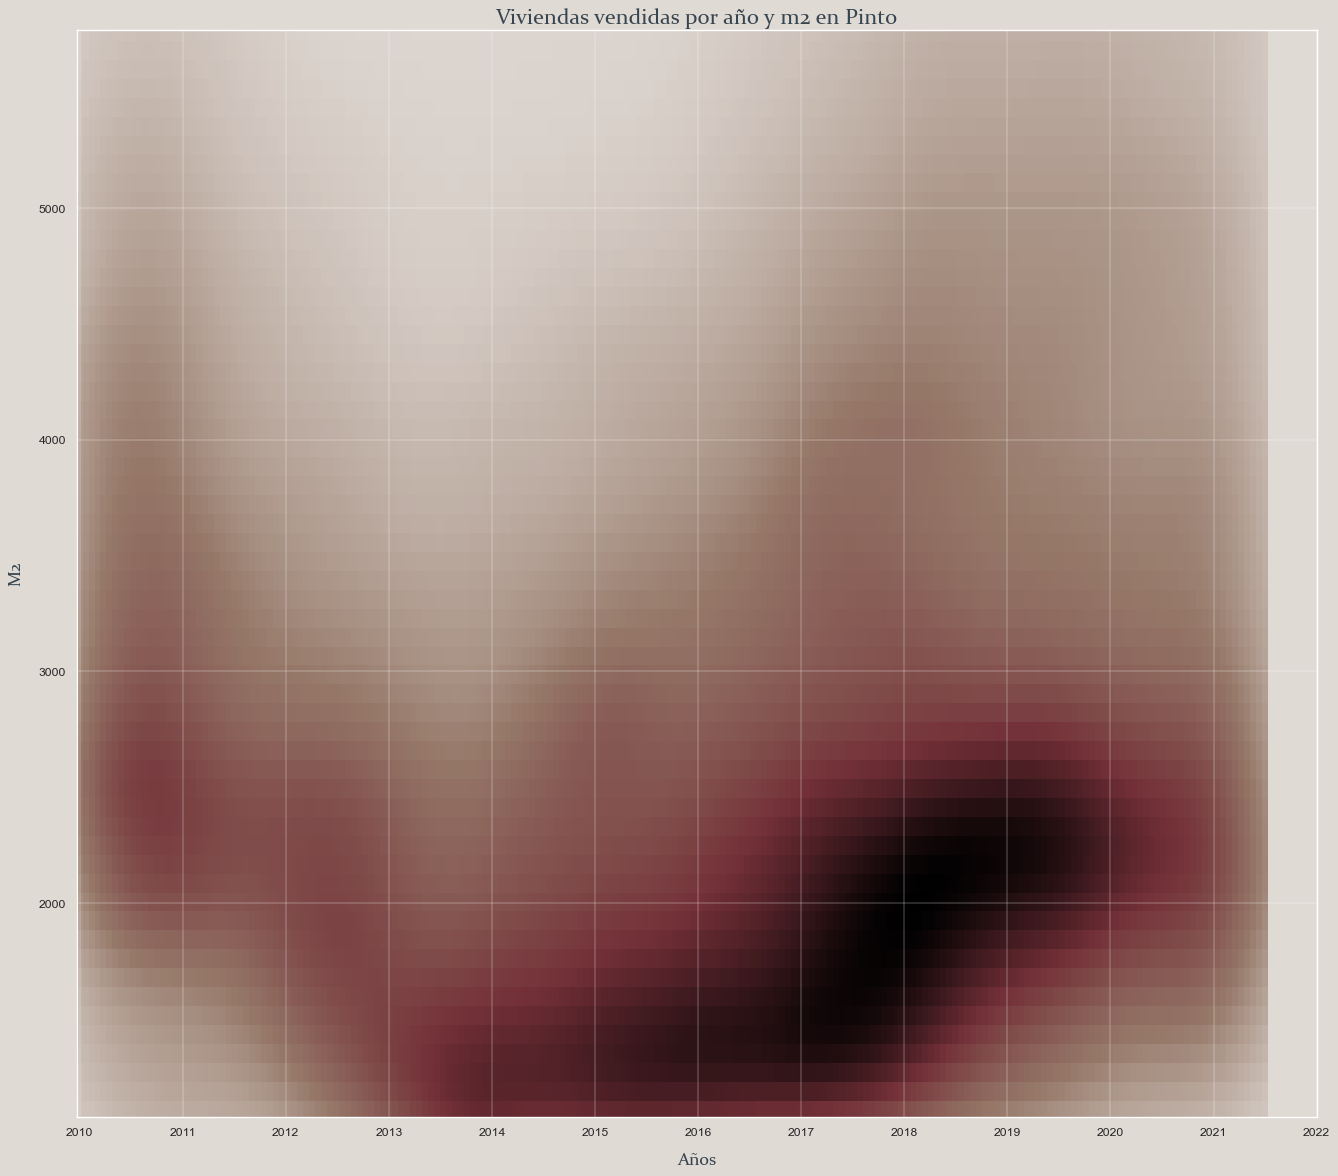

In [472]:
nbins = 200
town = 'Madrid'
dg = df.loc[(df.townName == town) & (df.tipo == 'pluri') & (df.built_sqm>60) & (df.built_sqm<90)]

x = dg.Fecha_Compraventa.apply(lambda x:x.timestamp()).astype('int')
y = dg.price_sqm_adj

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))



fig, ax = plt.subplots(figsize=(20, 18), dpi=80)
ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=cmap_bkrw, zorder=0)

ax.grid(True, color="w", lw=.3)

# plt.scatter(dg.Fecha_Compraventa.apply(lambda x:x.timestamp()).astype('int'), dg.built_sqm)

minyear = dg.Fecha_Compraventa.min().year
maxyear = dg.Fecha_Compraventa.max().year+1
locs = []
labels = []

for year in range(minyear, maxyear+1, 1):
    locs.append(pd.to_datetime(f'{year}-01-01').timestamp())
    labels.append(year)
plt.xticks(locs, labels)

plt.title(f'Viviendas vendidas por año y m2 en Pinto', color=dp.rgb(dp.CHARCOAL), size=20, fontname='Constantia')
ax.set_xlabel('Años', color=dp.rgb(dp.CHARCOAL), **labelstyle)
ax.set_ylabel('M2', color=dp.rgb(dp.CHARCOAL), **labelstyle)
ax.set_ylim([dg.price_sqm_adj.quantile(.05),dg.price_sqm_adj.quantile(.95)])
plt.show()

Observamos que entre 2017 y 2019 los pisos con más compraventas han ido disminuyendo de tamaño.

Al hacer la estimación de la densidad mediante kernel density estimator, para ver la distribución de los unitarios,
haremos varias rodajas de datos según el unitario.

<AxesSubplot:>

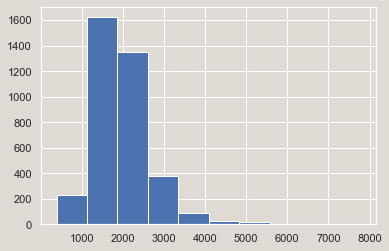

In [42]:
dg = df.loc[(df.townName == 'Pinto') & (df.tipo == 'pluri') & (df.built_sqm<150)]
dg.price_sqm_adj.hist()

Qué pisos son más comerciales ?

In [420]:
dg = df.loc[(df.tipo == 'pluri')].copy()
dg.built_sqm = dg.built_sqm.astype('int')

print(f'La distribución de superficies de los pisos tiene los parámetros\nmoda {int(dg.built_sqm.mode())} m2\nmediana {int(dg.built_sqm.median())} m2\nmedia {int(dg.built_sqm.mean())} m2\ncon std de {int(dg.built_sqm.std())} m2\nson los más habituales.\n')
print(f'La distribución de superficies de unitarios ajustados a la inflación tiene los parámetros\nmoda {int(dg.price_sqm_adj.mode())} €/m2\nmediana {int(dg.price_sqm_adj.median())} €/m2\nmedia {int(dg.price_sqm_adj.mean())} €/m2\ncon std de {int(dg.price_sqm_adj.std())} €/m2\nson los más habituales.')

La distribución de superficies de los pisos tiene los parámetros
moda 69 m2
mediana 82 m2
media 90 m2
con std de 41 m2
son los más habituales.

La distribución de superficies de unitarios ajustados a la inflación tiene los parámetros
moda 1512 €/m2
mediana 2125 €/m2
media 2536 €/m2
con std de 1555 €/m2
son los más habituales.


<AxesSubplot:>

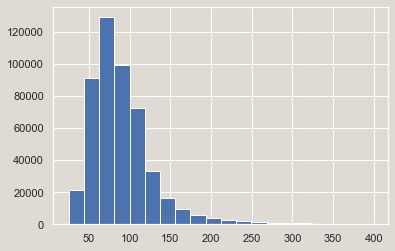

In [117]:
dg.built_sqm.hist(bins=20)

In [421]:
nbins = 50
town = 'Pinto'
ds = dg.loc[(dg.townName == town) & (dg.built_sqm >= 60) & (dg.built_sqm <= 100)].copy()

print(f'''
Vamos a quedarnos con los pisos en el rango 80 ± 20m2
por lo tanto vamos a coger el intervalo 60-100 m2,
que representa el {round(dg.loc[(dg.built_sqm >=60) & (dg.built_sqm <= 100)].shape[0] / dg.shape[0],4) * 100} % de la muestra total.

Dada la dispersión de las superficies, habrá que homogeneizar los unitarios
para traerlos al caso de 80m2, ajustando con 1% c/ 5m2.

Por ejemplo, los pisos de 100m2 verán incrementado su valor en 4%
y los pisos de 60m2 verán reducido su valor en 4%

Dada esta segmentación, tenemos {ds.shape[0]} datos,
de los cuales {round((dg.loc[(dg.townName == town)].shape[0]) / dg.shape[0],2)*100} % corresponden a la ciudad de {town}.

En este caso, la distribución de los unitarios ha variado,
siendo los parámetros de los unitarios ahora
moda {int(ds.price_sqm_adj.astype('int').mode())} €/m2
mediana {int(ds.price_sqm_adj.astype('int').median())} €/m2
media {int(ds.price_sqm_adj.astype('int').mean())} €/m2
std de {int(ds.price_sqm_adj.std())} €/m2
en el rango {int(ds.price_sqm_adj.min())} - {int(ds.price_sqm_adj.max())} €/m2
''')


Vamos a quedarnos con los pisos en el rango 80 ± 20m2
por lo tanto vamos a coger el intervalo 60-100 m2,
que representa el 51.39 % de la muestra total.

Dada la dispersión de las superficies, habrá que homogeneizar los unitarios
para traerlos al caso de 80m2, ajustando con 1% c/ 5m2.

Por ejemplo, los pisos de 100m2 verán incrementado su valor en 4%
y los pisos de 60m2 verán reducido su valor en 4%

Dada esta segmentación, tenemos 2105 datos,
de los cuales 1.0 % corresponden a la ciudad de Pinto.

En este caso, la distribución de los unitarios ha variado,
siendo los parámetros de los unitarios ahora
moda 1236 €/m2
mediana 1806 €/m2
media 1865 €/m2
std de 631 €/m2
en el rango 384 - 7789 €/m2



In [423]:
# Homogeneización por area
factor_ajuste_area = 1 + ((ds.built_sqm-80)/500)
ds['price_sqm_adj_hom'] = ds.price_sqm_adj * factor_ajuste_area

Cómo es el total ?

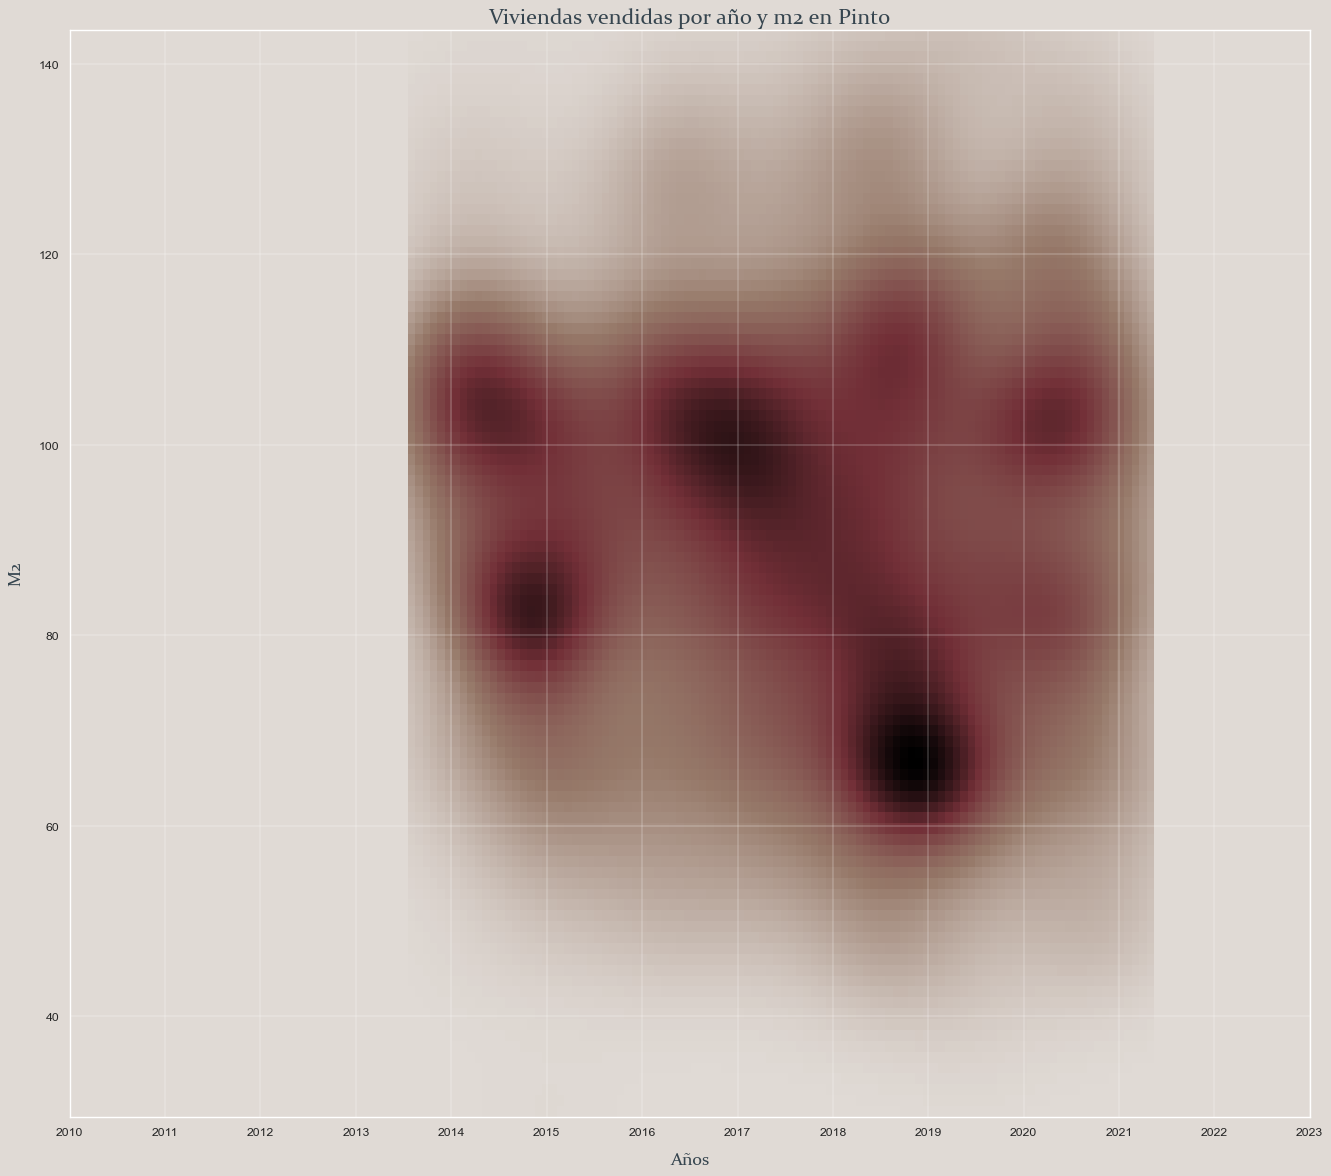

In [459]:
# Data division
nbins = 100
q95 = dg.loc[(dg.townName == town)].built_sqm.quantile(q=.95)
dtemp = dg.loc[(dg.townName == town) & (df.built_sqm < q95)].copy()
# dtemp = ds.loc[(ds.construction_year > 2005) & (ds.construction_year < 2010)] #df.loc[(df.townName == town)].copy()

x = dtemp.Fecha_Compraventa.apply(lambda x:x.timestamp()).astype('int')
y = dtemp.built_sqm

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))


# Data plot
fig, ax = plt.subplots(figsize=(20, 18), dpi=80)
ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=cmap_bkrw, zorder=0)
ax.grid(True, color="w", lw=.3)

minyear = dg.Fecha_Compraventa.min().year
maxyear = dg.Fecha_Compraventa.max().year+1
locs = []
labels = []

for year in range(minyear, maxyear+1, 1):
    locs.append(pd.to_datetime(f'{year}-01-01').timestamp())
    labels.append(year)
plt.xticks(locs, labels)

plt.title(f'Viviendas vendidas por año y m2 en {town}', color=dp.rgb(dp.CHARCOAL), size=20, fontname='Constantia')
ax.set_xlabel('Años', color=dp.rgb(dp.CHARCOAL), **labelstyle)
ax.set_ylabel('M2', color=dp.rgb(dp.CHARCOAL), **labelstyle)
plt.savefig(f'EDA/plot/kde/kde-{town}-{i}.png', transparent=True)

plt.show()

Cómo es según el mínimo y máximo ?

In [378]:
eur_sqm_min = int(ds.price_sqm_adj.min())
eur_sqm_max = int(ds.price_sqm_adj.max())
eur_sqm_std = (eur_sqm_max-eur_sqm_min)*.5 #6000
eur_sqm_max

16970

In [379]:
params = {}

for i, value in enumerate(np.arange(start=eur_sqm_min, stop=eur_sqm_max, step=eur_sqm_std)):
    color_ratio = value/eur_sqm_max
    params[i] = {'start':value, 'end':value+eur_sqm_std, 'color':cmap_color(color_ratio)}
    print(params[i])

{'start': 266.0, 'end': 8618.0, 'color': (0.38071510957324106, 0.5043906189926951, 0.7051134179161861, 1.0)}
{'start': 8618.0, 'end': 16970.0, 'color': (0.5144175317185697, 0.3338715878508266, 0.4338331410995771, 1.0)}


In [380]:
min_surface = ds.built_sqm.min()
max_surface = ds.built_sqm.max()

minyear = dg.Fecha_Compraventa.min().year
maxyear = dg.Fecha_Compraventa.max().year+1

ylim_range = [min_surface, max_surface]
xlim_range = [pd.to_datetime(f'{dg.Fecha_Compraventa.min().year}-01-01').timestamp(), pd.to_datetime(f'{dg.Fecha_Compraventa.max().year + 1}-01-01').timestamp()]

Escala de unitarios (eur/m2). Izquierda unitario bajo, derecha unitario alto.


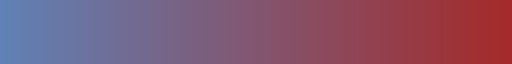

Escala densidad de población. Izquierda cantidad minima de datos, derecha cantidad maxima de datos.


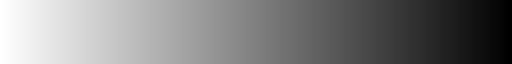

In [381]:
# Creamos dos escalas de color para indicar valores de unitarios y densidad de población

hc = [dp.hex_color(dp.GLAUCUS), dp.hex_color(dp.RED)]
th = [0, 1]
cdict = NonLinCdict(th, hc)
cmap_color = LinearSegmentedColormap('blue-red', cdict)

hc2 = ['#fff', '#000'] # dp.hex_color((50, 50, 50))
cdict2 = NonLinCdict(th, hc2)
cmap_kw = LinearSegmentedColormap('black-white', cdict2)

print('Escala de unitarios (eur/m2). Izquierda unitario bajo, derecha unitario alto.')
display(cmap_color)
print('Escala densidad de población. Izquierda cantidad minima de datos, derecha cantidad maxima de datos.')
display(cmap_kw)

In [382]:
densities = []
for i, value in params.items():
    dtemp = ds.loc[(ds.townName == town) & (ds.price_sqm_adj_hom >= params[i]['start']) & (ds.price_sqm_adj_hom < params[i]['end'])]
    densities.append(dtemp.shape[0] /ds.shape[0])

max_density = max(densities)

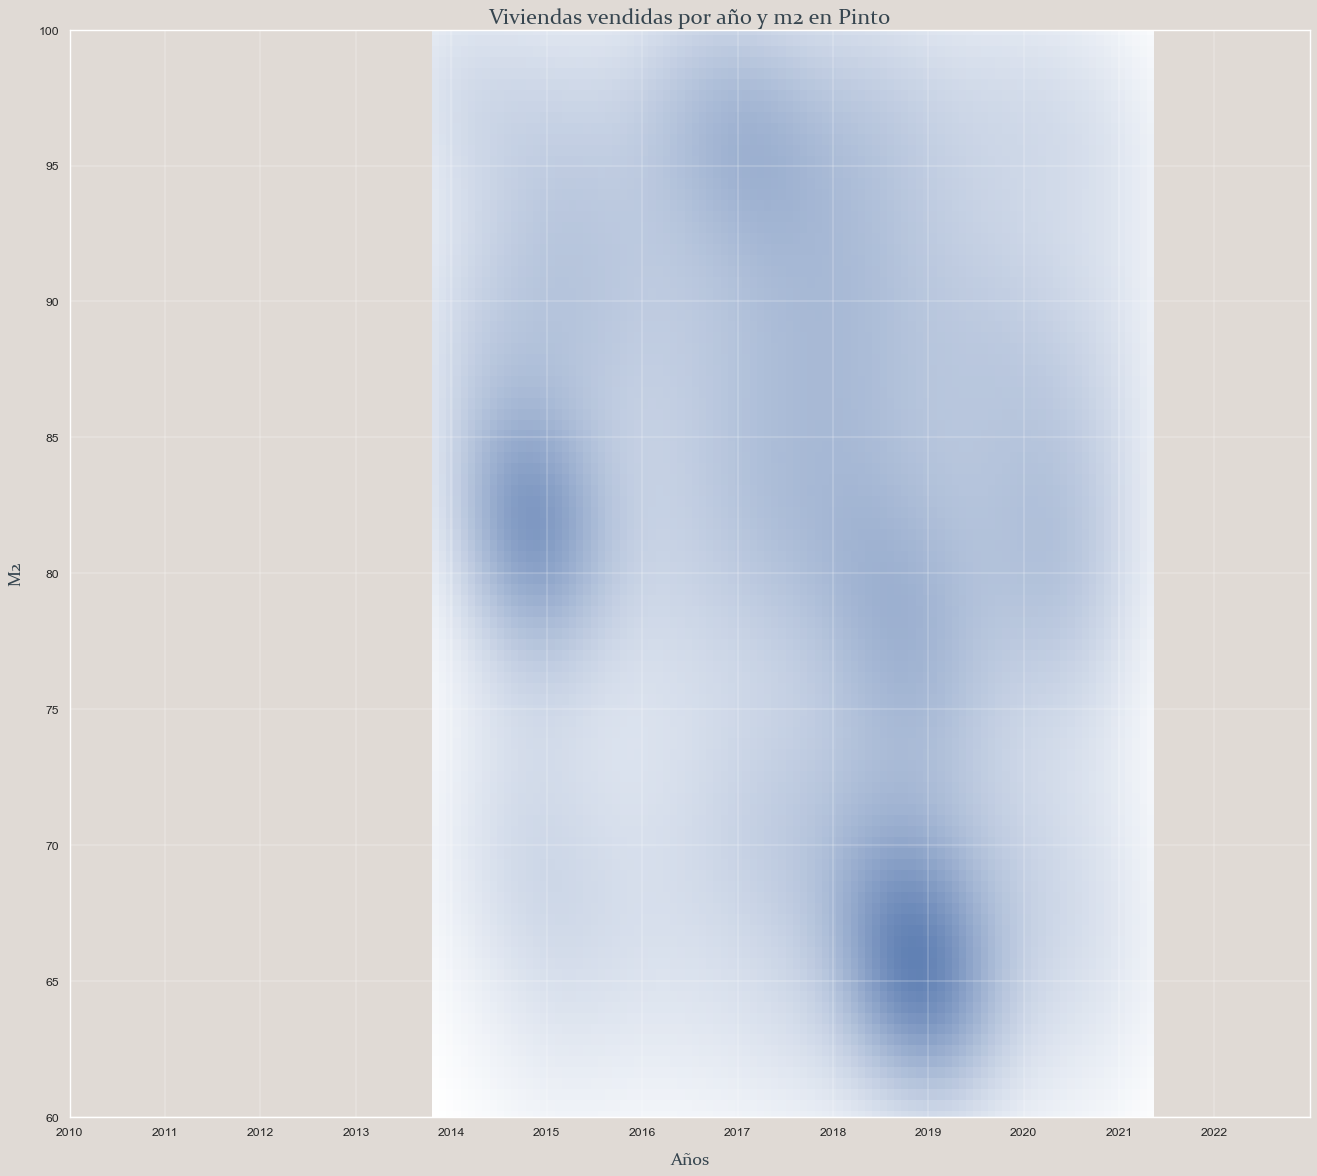

In [414]:
for i, value in params.items():
    # print(i, params[i]['color'])
    dtemp = ds.loc[(ds.townName == town) & (ds.price_sqm_adj_hom >= params[i]['start']) & (ds.price_sqm_adj_hom < params[i]['end'])]
    if dtemp.shape[0]>1:
        x = dtemp.Fecha_Compraventa.apply(lambda x:x.timestamp()).astype('int')
        y = dtemp.built_sqm

        # Create the cmap on the fly
        # quantity = dtemp.shape[0]/ds.shape[0]
        # density_color = cmap_kw(quantity/max_density)
        # combined_color = tuple([(x+y)/2 for x,y in zip(params[i]['color'], density_color)])
        # combined_color = (combined_color[0], combined_color[1], combined_color[2], quantity/max_density)
        # hc = [(1,1,1,0), combined_color]
        # th = [0, 1]
        # cdict = NonLinCdict(th, hc)
        # cmap_temp = LinearSegmentedColormap('temp', cdict)

        # Create cmap with max value being its actual eur_sqm
        hc = ['#fff', params[i]['color']]
        th = [0, 1]
        cdict = NonLinCdict(th, hc)
        cmap_temp = LinearSegmentedColormap('temp', cdict)

        # # Create transparent colormap
        # # get colormap
        # ncolors = 256
        # color_array = cmap_temp(range(ncolors))

        # # change alpha values
        # color_array[:,-1] = np.linspace(0,1,ncolors)

        # # create a colormap object
        # map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)


        # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
        k = kde.gaussian_kde([x,y])
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))

        # Plot graph
        fig, ax = plt.subplots(figsize=(20, 18), dpi=80)
        ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=cmap_temp, zorder=0)

        ax.grid(True, color="w", lw=.3)

        # plt.scatter(dg.Fecha_Compraventa.apply(lambda x:x.timestamp()).astype('int'), dg.built_sqm)

        locs = []
        labels = []

        for year in range(minyear, maxyear+1, 1):
            locs.append(pd.to_datetime(f'{year}-01-01').timestamp())
            labels.append(year)
        plt.xticks(locs, labels)
        plt.xlim(xlim_range)
        plt.ylim(ylim_range)

        plt.title(f'Viviendas vendidas por año y m2 en {town}', color=dp.rgb(dp.CHARCOAL), size=20, fontname='Constantia')
        ax.set_xlabel('Años', color=dp.rgb(dp.CHARCOAL), **labelstyle)
        ax.set_ylabel('M2', color=dp.rgb(dp.CHARCOAL), **labelstyle)
        plt.savefig(f'EDA/plot/kde/kde-{town}-{i}.png', transparent=True)
        plt.show()
        plt.close()

Creamos series de viviendas

In [89]:
df.price_sqm_adj = df.price_sqm_adj.round(-2).astype('int')


df['construction_decade'] = pd.cut(df.construction_year, bins=[1800,1950,2000,2022])
df['built_sqm_group'] = pd.cut(df.built_sqm, bins=[25,60,80,100,200,400])

df.construction_decade = df.construction_decade.astype('str')
df.built_sqm_group = df.built_sqm_group.astype('str')

df.vpo = df.vpo.replace(1,'vpo')
df.vpo = df.vpo.replace(0,'libre')

In [60]:
import gc
gc.collect()

105

Agrupamos las transacciones en función de diversos parámetros

In [88]:
dg = df[['townName','tipo','vpo','construction_decade','built_sqm_group','Fecha_Compraventa','price_sqm_adj']].copy()
result = dg.pivot_table(
        values='price_sqm_adj', 
        index=['Fecha_Compraventa'], 
        columns=['townName','tipo','vpo','construction_decade','built_sqm_group'], 
        aggfunc=np.median)

result.columns = ['_'.join(col).strip() for col in result.columns.values]
result.drop(columns=[col for col in result.columns if (col.startswith('_') | ('nan' in col))], inplace=True)
result.dropna(thresh=120,axis=1,inplace=True)
result.dropna(how='all',axis=0,inplace=True)
result.interpolate(inplace=True)

In [108]:
dg = df[['townName','tipo','vpo','Fecha_Compraventa','price_sqm_adj']].copy()
result_simple = dg.pivot_table(
        values='price_sqm_adj', 
        index=['Fecha_Compraventa'], 
        columns=['townName','tipo','vpo'], 
        aggfunc=np.median)

result_simple.columns = ['_'.join(col).strip() for col in result_simple.columns.values]
result_simple.drop(columns=[col for col in result_simple.columns if (col.startswith('_') | ('nan' in col))], inplace=True)
result_simple.dropna(thresh=100,axis=1,inplace=True)
result_simple.dropna(how='all',axis=0,inplace=True)
result_simple.interpolate(inplace=True)

In [115]:
dg = df[['tipo','vpo','Fecha_Compraventa','price_sqm_adj']].copy()
result_tipos = dg.pivot_table(
        values='price_sqm_adj', 
        index=['Fecha_Compraventa'], 
        columns=['tipo','vpo'], 
        aggfunc=np.median)

result_tipos.columns = ['_'.join(col).strip() for col in result_tipos.columns.values]
result_tipos.drop(columns=[col for col in result_tipos.columns if (col.startswith('_') | ('nan' in col))], inplace=True)
result_tipos.dropna(thresh=100,axis=1,inplace=True)
result_tipos.dropna(how='all',axis=0,inplace=True)
result_tipos.interpolate(inplace=True)
result_tipos

,pluri_libre,pluri_vpo,uni adosado_libre,uni adosado_vpo,uni chalet_libre
Fecha_Compraventa,,,,,
2010-01-01,3600.0,2300.0,2100.0,1200.0,4000.0
2010-02-01,3600.0,2300.0,1900.0,2500.0,3600.0
2010-03-01,3500.0,2400.0,2150.0,1650.0,4950.0
2010-04-01,3600.0,2300.0,2800.0,3100.0,3650.0
2010-05-01,3400.0,2100.0,1800.0,3050.0,3550.0
...,...,...,...,...,...
2021-04-01,2300.0,2200.0,1500.0,2100.0,1500.0
2021-05-01,2300.0,2100.0,1400.0,1900.0,1300.0
2021-06-01,2100.0,1900.0,1300.0,1200.0,1200.0


In [118]:
results = pd.concat([result,result_simple,result_tipos], axis=1)
results.reset_index(inplace=True)
results

,Fecha_Compraventa,"Guadalajara_pluri_libre_(1950, 2000]_(100, 200]","Guadalajara_pluri_libre_(1950, 2000]_(60, 80]","Guadalajara_pluri_libre_(1950, 2000]_(80, 100]","Guadalajara_pluri_libre_(2000, 2022]_(100, 200]","Guadalajara_pluri_libre_(2000, 2022]_(60, 80]","Guadalajara_pluri_libre_(2000, 2022]_(80, 100]","Guadalajara_pluri_vpo_(1950, 2000]_(80, 100]","Madrid_pluri_libre_(1800, 1950]_(100, 200]","Madrid_pluri_libre_(1800, 1950]_(200, 400]",...,Valdemoro_pluri_libre,Valdemoro_uni adosado_libre,Ávila_pluri_libre,Ávila_pluri_vpo,Ávila_uni adosado_libre,pluri_libre,pluri_vpo,uni adosado_libre,uni adosado_vpo,uni chalet_libre
0,2010-01-01,1150.0,1700.0,NaN,2400.0,2550.0,2500.0,2600.0,3800.0,3100.0,...,NaN,NaN,2000.0,1500.0,1700.0,3600.0,2300.0,2100.0,1200.0,4000.0
1,2010-02-01,2000.0,2500.0,2100.0,2550.0,2200.0,2650.0,1100.0,4200.0,5400.0,...,NaN,NaN,1900.0,1560.0,1750.0,3600.0,2300.0,1900.0,2500.0,3600.0
2,2010-03-01,2200.0,2075.0,1700.0,2200.0,3100.0,2850.0,2050.0,4250.0,5700.0,...,NaN,NaN,2200.0,1620.0,1750.0,3500.0,2400.0,2150.0,1650.0,4950.0
3,2010-04-01,2400.0,1650.0,2100.0,2900.0,2800.0,2900.0,2300.0,4500.0,6300.0,...,NaN,NaN,2100.0,1680.0,1600.0,3600.0,2300.0,2800.0,3100.0,3650.0
4,2010-05-01,1600.0,1500.0,1900.0,2450.0,2800.0,2800.0,1800.0,4300.0,4700.0,...,NaN,NaN,2300.0,1740.0,1700.0,3400.0,2100.0,1800.0,3050.0,3550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2021-04-01,1250.0,1000.0,1100.0,1200.0,2000.0,1800.0,1200.0,5200.0,5150.0,...,1750.0,1300.0,1000.0,900.0,1450.0,2300.0,2200.0,1500.0,2100.0,1500.0
136,2021-05-01,1100.0,1200.0,1300.0,1600.0,1550.0,1400.0,1400.0,5350.0,7000.0,...,2000.0,1300.0,1100.0,2300.0,1000.0,2300.0,2100.0,1400.0,1900.0,1300.0
137,2021-06-01,1600.0,1200.0,1200.0,1450.0,900.0,1250.0,900.0,4400.0,6700.0,...,1450.0,1300.0,1100.0,800.0,1000.0,2100.0,1900.0,1300.0,1200.0,1200.0
138,2021-07-01,1600.0,1200.0,1200.0,1450.0,900.0,1250.0,900.0,3400.0,6700.0,...,1450.0,1300.0,1100.0,800.0,1000.0,1500.0,1900.0,1200.0,1800.0,1100.0


In [119]:
results.to_sql('Series', con, if_exists='replace', index=False)

140

In [111]:
ordered_columns = results.corr().sum().sort_values(ascending=False).index.values
corr = results[ordered_columns].corr()

hc = [dp.hex_color(dp.GLAUCUS), '#000', '#fff', dp.hex_color(dp.RED)]
th = [0, 0.1, 0.9, 1]
cdict = NonLinCdict(th, hc)
cmap = LinearSegmentedColormap('test', cdict)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

<AxesSubplot:>

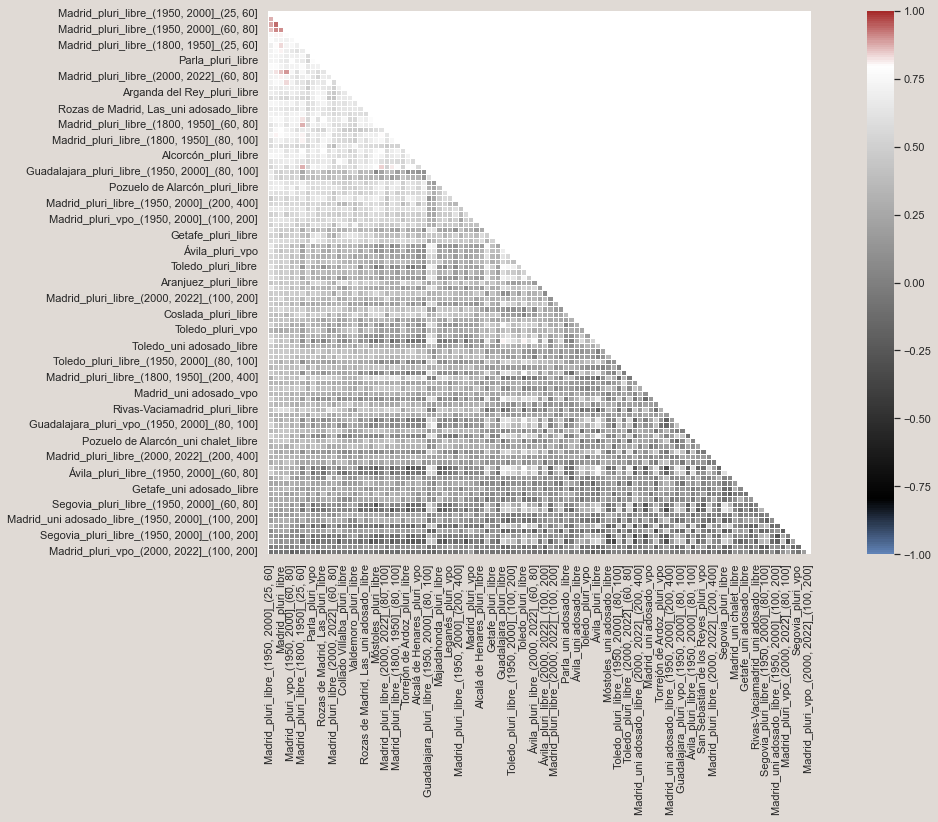

In [112]:
plot_properties = {'cbar':True, 'linewidths':.5,'mask':mask,'cmap':cmap,'vmin':-1,'vmax':1,'annot':False,'center':0,'square':True}
fig, ax = plt.subplots(figsize = (20,10), facecolor=dp.rgb(dp.BEIGE))
sns.heatmap(corr, ax=ax, **plot_properties)

En qué zonas de Madrid hay más transacciones ?

In [11]:
dcount = df.loc[df.townName == 'Madrid'][['censusSection','built_sqm']].groupby(by='censusSection').count().sort_values(by='built_sqm',ascending=False)
most_transactions_cs = dcount.axes[0][0]
print(f'La sección censal con más transacciones es: {most_transactions_cs}')

La sección censal con más transacciones es: 2807919052.0


In [186]:
# Definir coordenadas medias
x_coor_s = df.loc[df.censusSection == most_transactions_cs].x
x_coor = int(x_coor_s.min() + (x_coor_s.max() - x_coor_s.min())/2)

y_coor_s = df.loc[df.censusSection == most_transactions_cs].y
y_coor = int(y_coor_s.min() + (y_coor_s.max() - y_coor_s.min())/2)

# Coordenadas Sol
# # Primera gráfica
# x_coor = 440308-400
# y_coor = 4474206+200

# # Segunda gráfica
# x_coor = 440308-400
# y_coor = 4474206-800
# num_grafica = 2


# Segunda gráfica
x_coor = 440308-400
y_coor = 4474206+200
num_grafica = 3


ratio = 16/9
y_metros = 2000
x_metros = y_metros * ratio
x_metros, y_metros



(3555.555555555555, 2000)

In [187]:
# Definir transacciones dentro de los límites de las coordenadas
df2 = df.loc[((df.x > x_coor-x_metros) & (df.x < x_coor+x_metros)) & ((df.y > y_coor-y_metros) & (df.y < y_coor+y_metros))]
df2 = df2.loc[df2.Fecha_Compraventa > pd.to_datetime('2020-01-01')]
df2 = df2.loc[((df2.built_sqm > 60) & (df2.built_sqm < 100)) & (df2.tipo == 'pluri')]
df2 = df2.loc[df2.vpo == 0]
df2

,id,Fecha_Compraventa,Fecha_Real,address,no_rooms,no_floors,no_bathrooms,price_sqm,built_sqm,price,...,audited_area,property_type,non_discounted_price_sqm,parkingNumber,storageNumber,type_subtype,tipo,construction_year_date,x,y
46,24433515.0,2020-07-01,7/2020,"OLIVAR, 9",2.0,NaN,NaN,4088.0,75.82,310000.0,...,75.82,2.0,4088.0,NaN,NaN,1 - 6,pluri,1900-01-01,440475.555059,4.473633e+06
47,24433516.0,2020-12-01,12/2020,"OLIVAR, 9",2.0,NaN,NaN,3255.0,76.80,250000.0,...,76.80,2.0,3255.0,NaN,NaN,1 - 6,pluri,1900-01-01,440475.555059,4.473633e+06
48,24433517.0,2021-02-01,2/2021,"OLIVAR, 9",2.0,NaN,NaN,3505.0,75.60,265000.0,...,75.60,2.0,3505.0,NaN,NaN,1 - 6,pluri,1900-01-01,440475.555059,4.473633e+06
86,24541128.0,2021-05-01,5/2021,"ATOCHA, 78",2.0,NaN,NaN,4584.0,63.26,290000.0,...,63.26,2.0,4584.0,NaN,NaN,1 - 6,pluri,1994-01-01,440843.010528,4.473639e+06
104,24471722.0,2020-11-01,11/2020,"SANTA ISABEL, 16",3.0,NaN,NaN,3863.0,95.76,370000.0,...,95.76,2.0,3863.0,NaN,NaN,1 - 6,pluri,1980-01-01,440699.716652,4.473652e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771334,25388613.0,2020-11-01,11/2020,"MARQUES DE AHUMADA, 4",3.0,NaN,NaN,5421.0,95.18,516000.0,...,95.18,2.0,5421.0,NaN,NaN,1 - 6,pluri,2018-01-01,443219.304436,4.476387e+06
771385,25131155.0,2020-07-01,7/2020,"GENERAL PARDIÑAS, 112",2.0,NaN,NaN,8252.0,72.10,595000.0,...,72.10,2.0,8252.0,NaN,NaN,1 - 6,pluri,1960-01-01,442540.818241,4.476397e+06
771394,25269070.0,2020-11-01,11/2020,"BEJAR, 24",2.0,NaN,NaN,3977.0,79.20,315000.0,...,79.20,2.0,3977.0,NaN,NaN,1 - 6,pluri,1963-01-01,442926.751793,4.476397e+06
771429,25131102.0,2020-05-01,5/2020,"FRANCISCO SILVELA, 77",2.0,NaN,NaN,6324.0,87.75,555000.0,...,87.75,2.0,6324.0,NaN,NaN,1 - 6,pluri,1948-01-01,442599.374603,4.476401e+06


In [16]:
pob = gpd.read_file(r'data\ign\BTN\37043\BTN0507S_EDIFIC.shp')
pob = pob.to_crs("EPSG:25830")

c:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
c:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [21]:
pob2 = gpd.read_file(r'data\ign\BTN\37044\BTN0507S_EDIFIC.shp')
pob2 = pob2.to_crs("EPSG:25830")

c:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
c:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [194]:
pob3 = gpd.read_file(r'data\ign\BTN\38043\BTN0507S_EDIFIC.shp')
pob3 = pob3.to_crs("EPSG:25830")

c:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
c:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [192]:
pob4 = gpd.read_file(r'data\ign\BTN\38044\BTN0507S_EDIFIC.shp')
pob4 = pob4.to_crs("EPSG:25830")

c:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
c:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


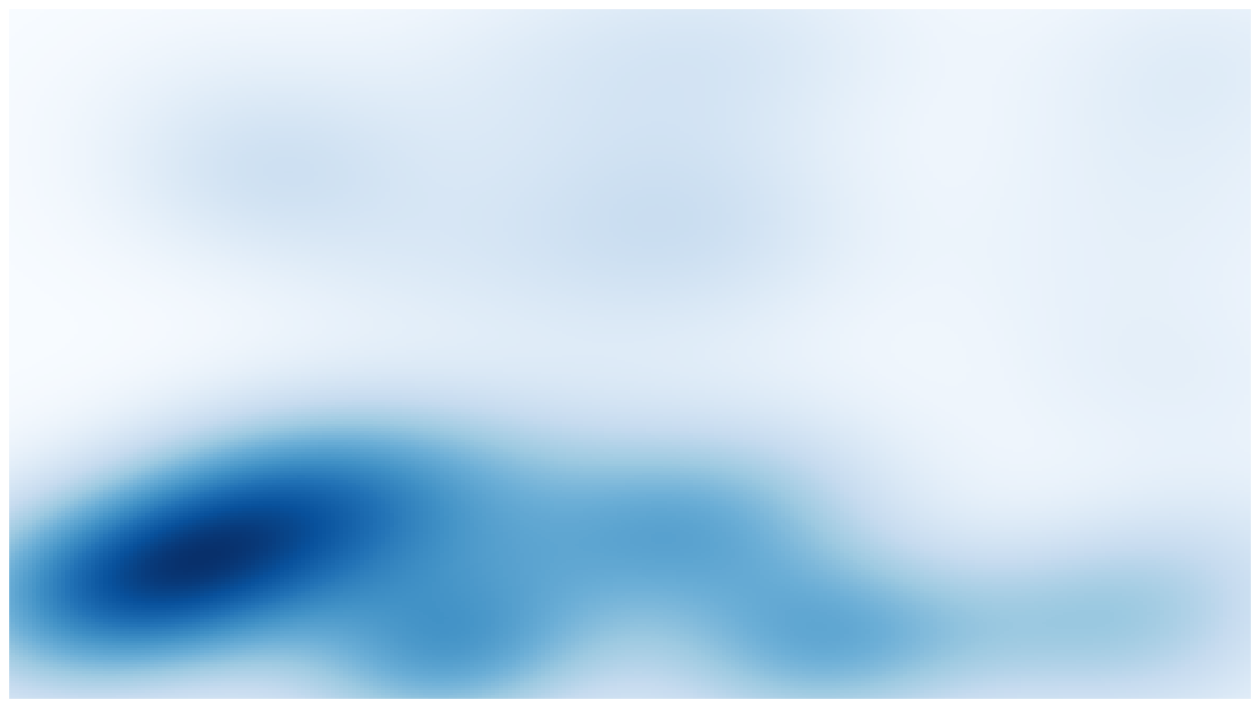

In [196]:
sns.set(rc={'axes.facecolor':(1,1,1), 'figure.facecolor':(1,1,1)})

tickstyle = {'colors':dp.rgb(dp.CHARCOAL)}
titlestyle = {'size':20, 'fontname':'Constantia','ha':'center', 'va':'center'}
labelstyle = {'size':18, 'fontname':'Constantia','ha':'center', 'va':'center'}
ticks_style = font_manager.FontProperties(family='Constantia', size=16, weight='normal', stretch='normal')


dfbarato = df2.loc[df2.price_sqm<4000]
dfcaro = df2.loc[df2.price_sqm>4000]

dfcalc = dfbarato

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
x = dfcalc.x
y = dfcalc.y
nbins = 300
hc = ['#fff', dp.rgb((210, 125, 45)), dp.rgb(dp.RED)]
th = [0, .5, 1]
cdict = NonLinCdict(th, hc)
cmap_temp = LinearSegmentedColormap('temp', cdict)


k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))


#cmap = matplotlib.cm.get_cmap('winter')
#cmap = plt.get_cmap('coolwarm')
cmap = plt.get_cmap('Oranges')
cmap_2 = plt.get_cmap('Blues')

norm = plt.Normalize(-1, 90)

# PLOT
fig, ax = plt.subplots(figsize=(16, 9), dpi=80)

# pob.plot(ax=ax, color='0', linewidth=0)
# pob2.plot(ax=ax, color='0', linewidth=0)

ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=cmap_2, zorder=0)
ax.set_aspect('equal')

x_limits = [x_coor-x_metros+50,x_coor+x_metros-50]
y_limits = [y_coor-y_metros+50,y_coor+y_metros-50]
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
'''
ax.set_xlim(350_000,530_000)
ax.set_ylim(4_375_000,4_570_000)
'''
# Change tick styles
ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
for label in ax.get_xticklabels(): label.set_fontproperties(ticks_style)
for label in ax.get_yticklabels(): label.set_fontproperties(ticks_style)
ax.set_xticks([])
ax.set_yticks([])
# plt.suptitle('Concentración de transacciones a partir de 2020 de pisos libres en Madrid\ncon superficies entre 60 y 80 m2 y precios mayores y menores de 4.000€/m2', **titlestyle)
plt.tight_layout()
# plt.ylabel('')
# plt.xlabel('Año de construcción', **labelstyle)
plt.savefig(f'EDA/plot/RealEstate/plano_{num_grafica}_menores4000.png')
plt.show()
plt.close()

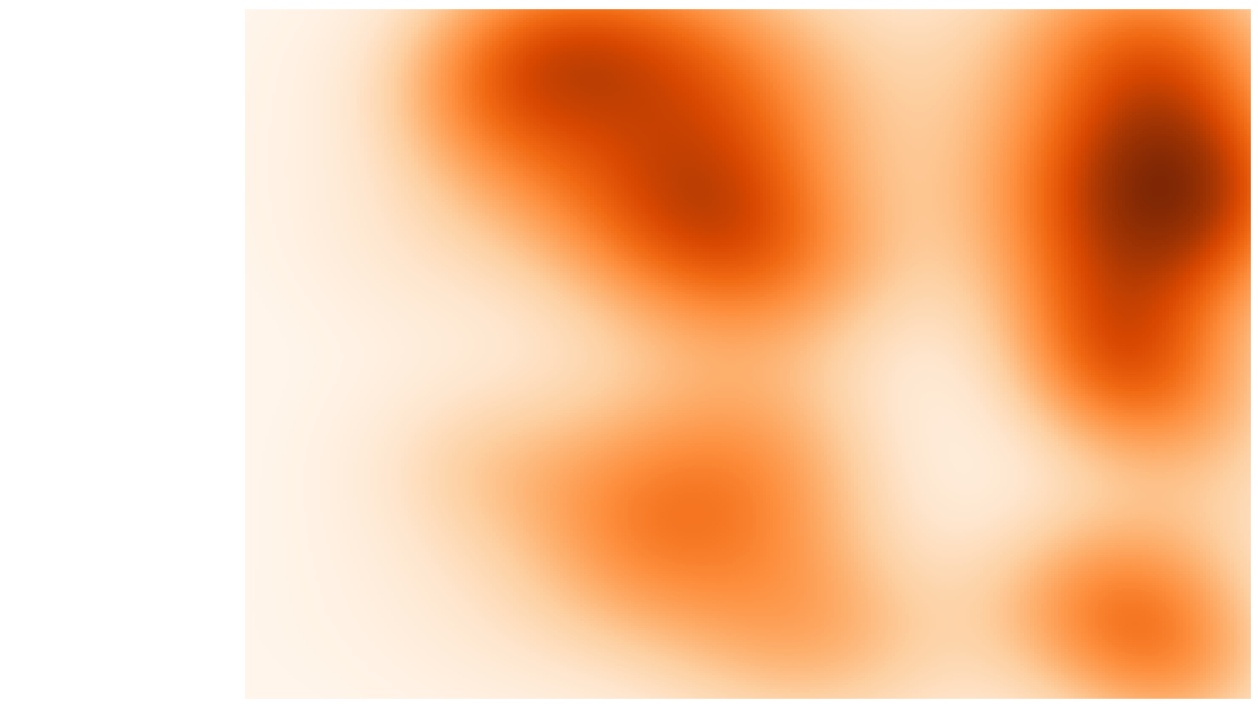

In [197]:
tickstyle = {'colors':dp.rgb(dp.CHARCOAL)}
titlestyle = {'size':20, 'fontname':'Constantia','ha':'center', 'va':'center'}
labelstyle = {'size':18, 'fontname':'Constantia','ha':'center', 'va':'center'}
ticks_style = font_manager.FontProperties(family='Constantia', size=16, weight='normal', stretch='normal')
dfcalc = dfcaro
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
x = dfcalc.x
y = dfcalc.y
nbins = 300
hc = ['#fff', dp.rgb((210, 125, 45)), dp.rgb(dp.RED)]
th = [0, .5, 1]
cdict = NonLinCdict(th, hc)
cmap_temp = LinearSegmentedColormap('temp', cdict)


k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))


#cmap = matplotlib.cm.get_cmap('winter')
#cmap = plt.get_cmap('coolwarm')
cmap = plt.get_cmap('Oranges')
cmap_2 = plt.get_cmap('Blues')

norm = plt.Normalize(-1, 90)

# PLOT
fig, ax = plt.subplots(figsize=(16, 9), dpi=80)

# pob.plot(ax=ax, color='0', linewidth=0)
# pob2.plot(ax=ax, color='0', linewidth=0)

ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=cmap, zorder=0)
ax.set_aspect('equal')

ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
'''
ax.set_xlim(350_000,530_000)
ax.set_ylim(4_375_000,4_570_000)
'''
# Change tick styles
ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
for label in ax.get_xticklabels(): label.set_fontproperties(ticks_style)
for label in ax.get_yticklabels(): label.set_fontproperties(ticks_style)
ax.set_xticks([])
ax.set_yticks([])
# plt.suptitle('Concentración de transacciones a partir de 2020 de pisos libres en Madrid\ncon superficies entre 60 y 80 m2 y precios mayores y menores de 4.000€/m2', **titlestyle)
plt.tight_layout()
# plt.ylabel('')
# plt.xlabel('Año de construcción', **labelstyle)
plt.savefig(f'EDA/plot/RealEstate/plano_{num_grafica}_mayores4000.png')
plt.show()
plt.close()

In [117]:
# sns.set(rc={'axes.facecolor':(dp.rgb(dp.BEIGE)), 'figure.facecolor':dp.rgb(dp.BEIGE)})
sns.set(rc={'axes.facecolor':(1,1,1), 'figure.facecolor':(1,1,1)})


c:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
c:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
c:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Itera

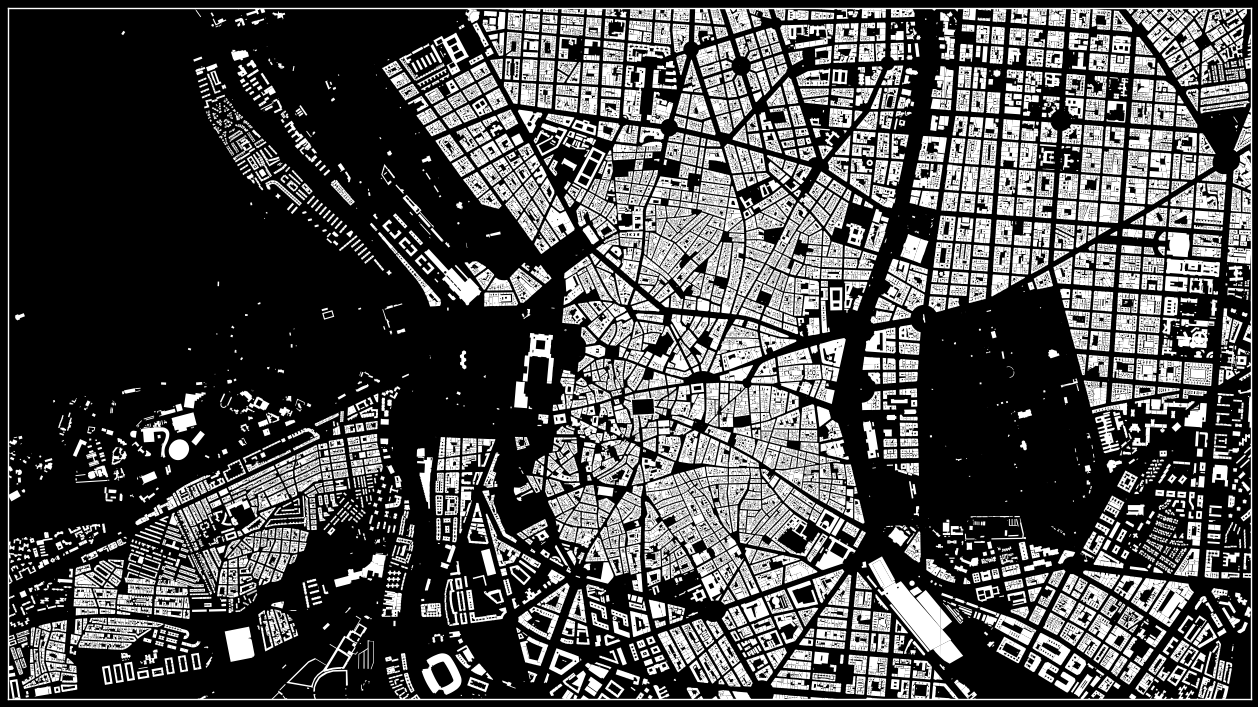

In [195]:
sns.set(rc={'axes.facecolor':(0,0,0), 'figure.facecolor':(0,0,0)})

# PLOT
fig, ax = plt.subplots(figsize=(16, 9), dpi=80)

pob.plot(ax=ax, color='1', linewidth=0)
pob2.plot(ax=ax, color='1', linewidth=0)
pob3.plot(ax=ax, color='1', linewidth=0)
pob4.plot(ax=ax, color='1', linewidth=0)

# ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=cmap, zorder=0)
ax.set_aspect('equal')

ax.set_xlim(x_limits)
ax.set_ylim(y_limits)

# Change tick styles
ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
for label in ax.get_xticklabels(): label.set_fontproperties(ticks_style)
for label in ax.get_yticklabels(): label.set_fontproperties(ticks_style)

# ax.text(438800, 4474500, f'Concentración de transacciones a partir de 2020 de pisos libres en Madrid\ncon superficies entre 60 y 80 m2 y precios mayores y menores de 4.000€/m2',
#         size=16, fontname='Constantia', color='w')

# plt.suptitle('Concentración de transacciones a partir de 2020 de pisos libres en Madrid\ncon superficies entre 60 y 80 m2 y precios mayores y menores de 4.000€/m2', **titlestyle)
# plt.ylabel('')
# plt.xlabel('Año de construcción', **labelstyle)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig(f'EDA/plot/RealEstate/plano__{num_grafica}_base.png')

plt.show()
plt.close()